# Detecção de anomalias em poços produtores de petróleo usando aprendizado de máquina

**_Principais Referências_**
  
- **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** ([link](https://doi.org/10.1016/j.petrol.2019.106223)).
- **Github de referência do _benchmark_ proposto por Vargas (2019)** ([link](https://github.com/ricardovvargas/3w_dataset)).

## 1. Regras do benchmark proposto por Vargas (2019)

- Apenas instâncias reais com anomalias de tipos que têm períodos normais maiores ou iguais a vinte minutos foram utilizadas;

- Múltiplas rodadas de treinamento e validação realizadas, sendo o número de rodadas igual ao número de instâncias. Em cada rodada, amostras utilizadas para treinamento ou validação extraídas de apenas uma instância. Parte das amostras de normalidade utilizadas no treinamento e a outra parte na validação. Todas as amostras de anomalias devem ser utilizadas apenas na validação, sendo, portanto, uma técnica de aprendizagem de classe única. O conjunto de validação deve ser composto pelo mesmo número de amostras de cada classe (normalidade e anormalidade);

- Em cada rodada, precisão, revogação e medida F1 devem ser computadas (valor médio e desvio padrão de cada métrica), sendo o valor médio da medida F1 considerado a principal métrica de desempenho.

## 1.1 Outras definições adotadas

- Uma estratégia de amostragem específica com janela deslizante foi usada para cada tipo de período. Em períodos normais, as primeiras observações são usadas para treinamento e as últimas são usadas para testes. Em períodos transientes, procura-se usar observações como um todo (apenas para teste). Em períodos de regime, as primeiras observações são privilegiadas (somente para teste);

- Antes de cada rodada de treinamento e teste:
    - As amostras utilizadas (não as instâncias) são adequadamente normalizadas com o z-score;
    - As variáveis de amostras (não as instâncias) usadas para treinamento que possuem um número de NaNs acima de um limite ou que têm um desvio padrão abaixo de um outro limite são descartadas.

- Todos os random_state necessários são atribuídos a uma constante para que os resultados sejam reproduzíveis.

## 2. Bibliotecas e configurações

In [1]:
# Artifício para alcular tempo total do notebook Jupyter
from datetime import datetime 
start_time = datetime.now()

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import logging
import warnings
import sys
sys.path.append('stac')
import nonparametric_tests as stac
from math import ceil
from matplotlib import pyplot as plt
from time import time
from pathlib import Path
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support

In [3]:
logging.getLogger('tsfresh').setLevel(logging.ERROR)
warnings.simplefilter(action='ignore')

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [5]:
data_path = Path('./', 'data')
random_state = 1
events_names = {0: 'Normal',
                1: 'Aumento Abrupto de BSW',
                2: 'Fechamento Espúrio de DHSV',
                3: 'Intermitência Severa',
                4: 'Instabilidade de Fluxo',
                5: 'Perda Rápida de Produtividade',
                6: 'Restrição Rápida em CKP',
                7: 'Incrustação em CKP',
                8: 'Hidrato em Linha de Produção'
               }
vars = ['P-PDG',
        'P-TPT',
        'T-TPT',
        'P-MON-CKP',
        'T-JUS-CKP',
        'P-JUS-CKGL',
        'T-JUS-CKGL',
        'QGL']
columns = ['timestamp'] + vars + ['class'] 
normal_class_code = 0
abnormal_classes_codes = [1, 2, 5, 6, 7, 8]
sample_size = 3*60              # Nas observações = segundos
min_normal_period_size = 20*60  # Nas observações = segundos
split_range = 0.6               # Porcentagem de separação entre treino/teste
max_samples_per_period = 15     # limitação por 'segurança'
df_fc_p = MinimalFCParameters() # Ver documentação da biblioteca tsfresh
#df_fc_p = EfficientFCParameters()
df_fc_p.pop('sum_values')       # Remove feature inapropriada
df_fc_p.pop('length')           # Remove feature inapropriada
max_nan_percent = 0.1           # Para seleção de variáveis úteis
std_vars_min = 0.01             # Para seleção de variáveis úteis
disable_progressbar = True      # Para menos saídas no notebook

In [6]:
def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    """Gerador de lista contendo número da classe e caminho do arquivo de acordo com a fonte da instância."""    
    for class_path in data_path.iterdir():
        if class_path.is_dir():
            class_code = int(class_path.stem)
            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path

In [7]:
def load_instance(instance_path):
    """Função que carrega cada instância individualmente"""
    try:
        well, instance_id = instance_path.stem.split('_')
        df = pd.read_csv(instance_path, sep=',', header=0)
        assert (df.columns == columns).all(), \
            f'Colunas inválidas no arquivo {str(instance_path)}: {str(df.columns.tolist())}'
        return df
    except Exception as e:
        raise Exception(f'Erro ao ler arquivo {instance_path}: {e}')

In [8]:
def extract_samples(df, class_code):
    # Obtém os rótulos das observações e seu conjunto inequívoco
    ols = list(df['class'])
    set_ols = set()
    for ol in ols:
        if ol in set_ols or np.isnan(ol):
            continue
        set_ols.add(int(ol))       
    
    # Descarta os rótulos das observações e substitui todos os nan por 0
    # (requisito da biblioteca tsfresh)
    df_vars = df.drop('class', axis=1).fillna(0)  
    
    # Inicializa objetos que serão retornados
    df_samples_train = pd.DataFrame()
    df_samples_test = pd.DataFrame()
    y_train = []
    y_test = []
            
    # Descubre o número máximo de amostras em períodos normais, transitórios e em regime
    # Obtém índices (primeiro e último) sem sobreposição com outros períodos
    f_idx = ols.index(normal_class_code)
    l_idx = len(ols)-1-ols[::-1].index(normal_class_code)

    # Define o número inicial de amostras para o período normal
    max_samples_normal = l_idx-f_idx+1-sample_size
    if (max_samples_normal) > 0:      
        num_normal_samples = min(max_samples_per_period, max_samples_normal)
        num_train_samples = int(split_range*num_normal_samples)
        num_test_samples = num_normal_samples - num_train_samples    
    else:
        num_train_samples = 0
        num_test_samples = 0
    
    # Define o número máximo de amostras por período transitório
    transient_code = class_code + 100    
    if transient_code in set_ols:
        # Obtém índices (primeiro e último) com possível sobreposição
        # no início do período
        f_idx = ols.index(transient_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(transient_code)        
        max_transient_samples = l_idx-f_idx+1-sample_size
    else:
        max_transient_samples = 0            

    # Define o número máximo de amostras no período de regime
    if class_code in set_ols:
        # Obtém índices (primeiro e último) com possível sobreposição 
        # no início ou fim do período
        f_idx = ols.index(class_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(class_code)
        if l_idx+(sample_size-1) < len(ols)-1:
            l_idx = l_idx+(sample_size-1) 
        else:
            l_idx = len(ols)-1
        max_in_regime_samples = l_idx-f_idx+1-sample_size
    else:
        max_in_regime_samples = 0   
        
    # Descubre o número adequado de amostras em períodos normais, transitórios e em regime
    num_transient_samples = ceil(num_test_samples/2)
    num_in_regime_samples = num_test_samples - num_transient_samples
    if (max_transient_samples >= num_transient_samples) and \
       (max_in_regime_samples < num_in_regime_samples):
        num_in_regime_samples = max_in_regime_samples        
        num_transient_samples = min(num_test_samples-num_in_regime_samples, max_transient_samples)
    elif (max_transient_samples < num_transient_samples) and \
         (max_in_regime_samples >= num_in_regime_samples):
        num_transient_samples = max_transient_samples        
        num_in_regime_samples = min(num_test_samples-num_transient_samples, max_in_regime_samples)
    elif (max_transient_samples < num_transient_samples) and \
         (max_in_regime_samples < num_in_regime_samples):
        num_transient_samples = max_transient_samples
        num_in_regime_samples = max_in_regime_samples
        num_test_samples = num_transient_samples+num_in_regime_samples
    
    # Extrai amostras do período normal para treinamento e teste
    # Obtém índices (primeiro e último) sem sobreposição com outros períodos
    f_idx = ols.index(normal_class_code)
    l_idx = len(ols)-1-ols[::-1].index(normal_class_code)
    
    # Define a etapa correta e extrai amostras
    if (num_normal_samples) > 0:  
        if num_normal_samples == max_samples_normal:
            step_max = 1 
        else:
            step_max = (max_samples_normal-1) // (max_samples_per_period-1)
        step_wanted = sample_size
        step = min(step_wanted, step_max)
        
        # Extrai amostras para treinamento
        sample_id = 0
        for idx in range(num_train_samples):
            f_idx_c = l_idx-sample_size+1-(num_normal_samples-1-idx)*step
            l_idx_c = f_idx_c+sample_size
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_train = df_samples_train.append(df_sample)
            y_train.append(normal_class_code)
            sample_id += 1
    
        # Extrai amostras para teste
        sample_id = 0
        for idx in range(num_train_samples, num_train_samples+num_test_samples):
            f_idx_c = l_idx-sample_size+1-(num_normal_samples-1-idx)*step
            l_idx_c = f_idx_c+sample_size
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(normal_class_code)
            sample_id += 1

    # Extrai amostras do período transitório (se existir) para teste
    if (num_transient_samples) > 0:    
        # Define a etapa correta e extrai amostras
        if num_transient_samples == max_transient_samples:
            step_max = 1 
        else:
            step_max = (max_transient_samples-1) // (max_samples_per_period-1)
        step_wanted = np.inf
        step = min(step_wanted, step_max)
        
        # Obtém índices (primeiro e último) com possível sobreposição no início deste período
        f_idx = ols.index(transient_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(transient_code) 

        # Extrai amostras
        for idx in range(num_transient_samples):
            f_idx_c = f_idx+idx*step
            l_idx_c = f_idx_c+sample_size
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(transient_code)
            sample_id += 1
            
    # Extrai amostras do período em regime (se existir) para teste
    if (num_in_regime_samples) > 0:     
        # Define a etapa correta e extrai amostras
        if num_in_regime_samples == max_in_regime_samples:
            step_max = 1 
        else:
            step_max = (max_in_regime_samples-1) // (max_samples_per_period-1)
        step_wanted = sample_size
        step = min(step_wanted, step_max)
        
        # Obtém índices (primeiro e último) com possível sobreposição 
        # no início ou no final deste período
        f_idx = ols.index(class_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(class_code)
        if l_idx+(sample_size-1) < len(ols)-1:
            l_idx = l_idx+(sample_size-1) 
        else:
            l_idx = len(ols)-1

        # Extrai amostras
        for idx in range(num_in_regime_samples):
            f_idx_c = f_idx+idx*step
            l_idx_c = f_idx_c+sample_size
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(class_code)
            sample_id += 1

    return df_samples_train, y_train, df_samples_test, y_test              

In [9]:
def train_test_calc_scores(X_train, y_train, X_test, y_test, scores, clfs):
    X_train.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)    
    for clf_name, clf in clfs.items():
        print('y_train')
        print(y_train)
        print('y_test')
        print(y_test)
        
        # Treino
        t0 = time()
        clf.fit(X_train, y_train)
        t_train = time() - t0

        # Teste
        t0 = time()
        y_pred = clf.predict(X_test)
        print(f'y_pred - {clf_name}')
        print(y_pred)
        t_test = time() - t0

        # Plota os labels reais e preditos pelo classificador
        fig = plt.figure(figsize=(12,1))
        ax = fig.add_subplot(111)
        plt.plot(y_pred, marker=11, color='orange', linestyle='') 
        plt.plot(y_test, marker=10, color='green', linestyle='') 
        ax.grid(False)
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['Normal', 'Anormal'])
        ax.set_title(clf_name)            
        ax.set_xlabel('Amostra')
        ax.legend(['Classe Prevista', 'Classe Real'])
        plt.show()

        # Calcula as metricas de desempenho
        ret = precision_recall_fscore_support(y_test, y_pred, average='micro')
        p, r, f1, _ = ret
        scores = scores.append({'CLASSIFICADOR': clf_name, 
                                'PRECISAO': p,
                                'REVOGACAO': r,
                                'F1': f1,
                                'TREINAMENTO [s]': t_train, 
                                'TESTE [s] ': t_test}, ignore_index=True)  
    return scores

In [10]:
# Gets all real instances but maintains only those with any type of undesirable event
real_instances = pd.DataFrame(class_and_file_generator(data_path, 
                                                       real=True,
                                                       simulated=False, 
                                                       drawn=False),
                              columns=['class_code', 'instance_path'])
real_instances = real_instances.loc[real_instances.iloc[:,0].isin(abnormal_classes_codes)].reset_index(drop=True)

Instância 1: data\1\WELL-00001_20140124213136.csv
	ignorado porque normal_period_size é insuficiente para treinamento (959)

Instância 2: data\1\WELL-00002_20140126200050.csv
	ignorado porque normal_period_size é insuficiente para treinamento (1138)

Instância 3: data\1\WELL-00006_20170801063614.csv


Using TensorFlow backend.


y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 248       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
___________________________________________________________

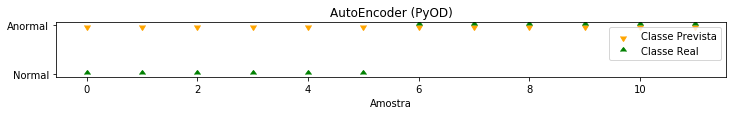

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 0 1 1 1 1 1]


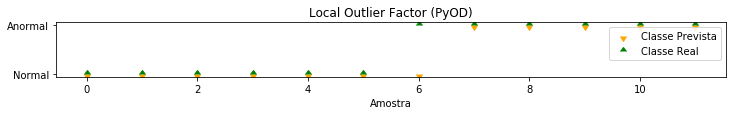

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[1 0 1 1 1 1 1 1 1 1 1 1]


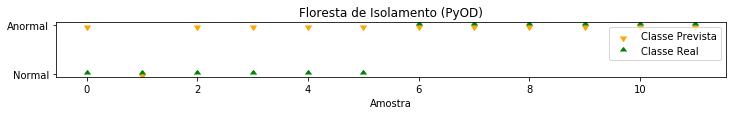

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


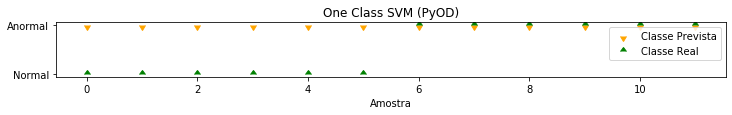

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[0 1 1 1 1 1 1 1 1 1 1 1]


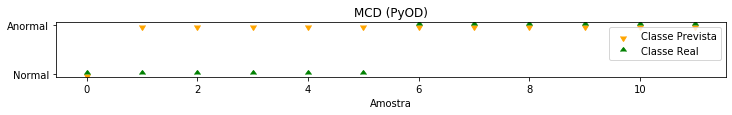

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


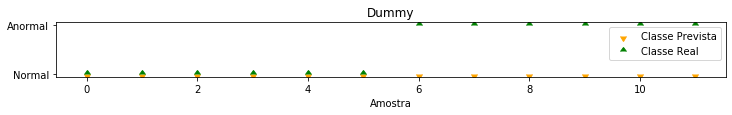

Instância 4: data\1\WELL-00006_20170802123000.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 24)                600       
_________________________________________________________________
dropout_7 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 24)                600       
_________________________________________________________________
dropout_8 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 200       
_________________________________________________________________
dropout_9 (Dropout)          (None, 8)                 0         
_________

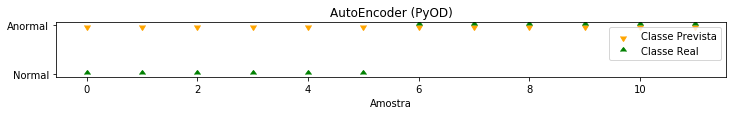

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 0 1 1 1 1 1]


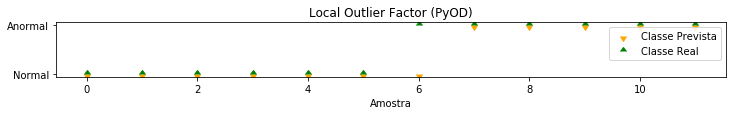

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 0 0 0 0 0 0 0 0]


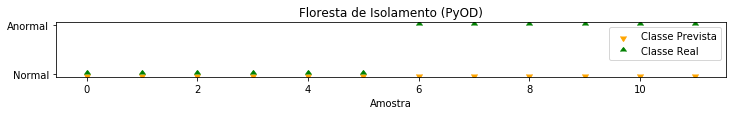

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[0 1 1 1 1 1 1 1 1 1 1 1]


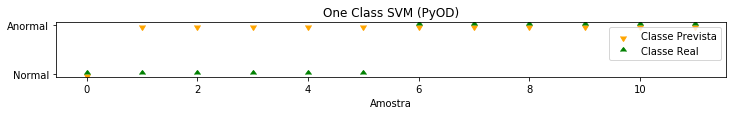

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


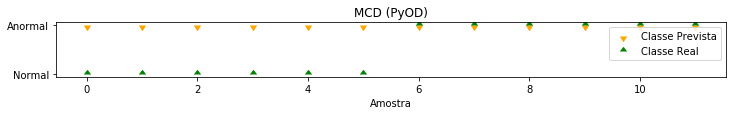

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


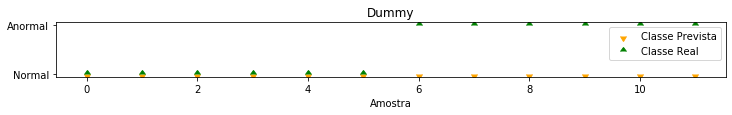

Instância 5: data\1\WELL-00006_20180618060245.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 30)                930       
_________________________________________________________________
dropout_13 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 30)                930       
_________________________________________________________________
dropout_14 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 248       
_________________________________________________________________
dropout_15 (Dropout)         (None, 8)                 0         
_________

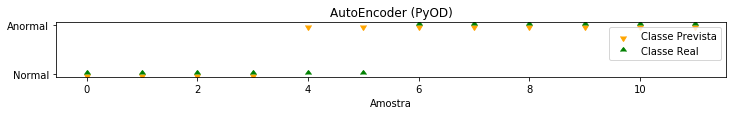

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 1 1 1 1 1 1]


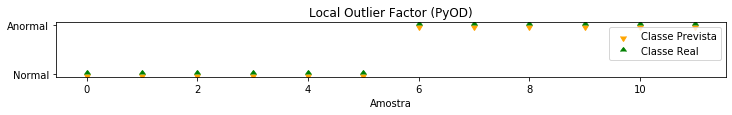

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 0 0 0 0 0 0 1 0]


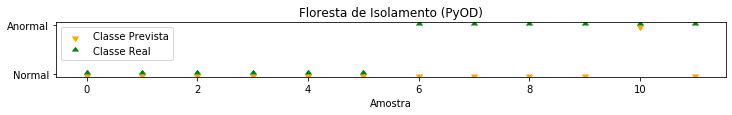

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


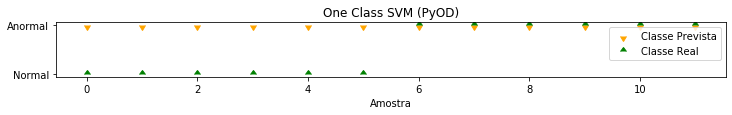

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


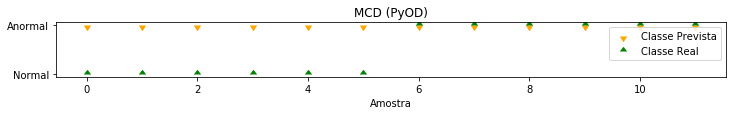

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


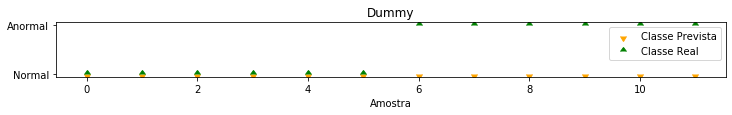

Instância 6: data\2\WELL-00002_20131104014101.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 18)                342       
_________________________________________________________________
dropout_19 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 18)                342       
_________________________________________________________________
dropout_20 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 152       
_________________________________________________________________
dropout_21 (Dropout)         (None, 8)                 0         
_________

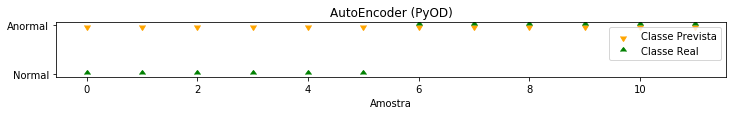

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 1 1 1 1 1 1 1 1 1]


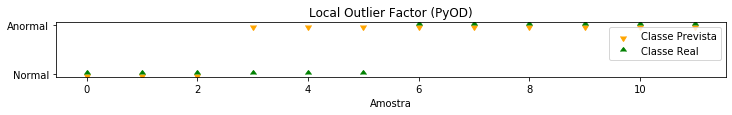

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


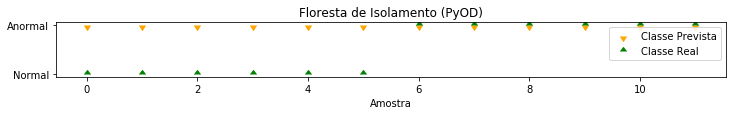

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


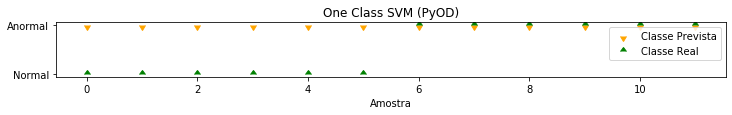

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[1 0 1 1 1 1 1 1 1 1 1 1]


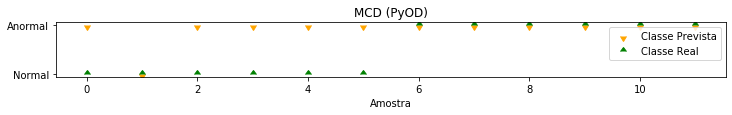

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


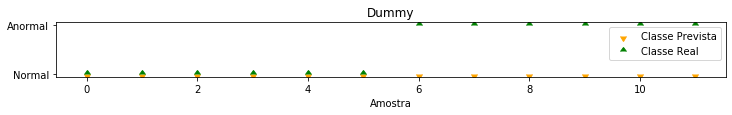

Instância 7: data\2\WELL-00003_20141122214325.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 24)                600       
_________________________________________________________________
dropout_25 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 24)                600       
_________________________________________________________________
dropout_26 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 8)                 200       
_________________________________________________________________
dropout_27 (Dropout)         (None, 8)                 0         
_________

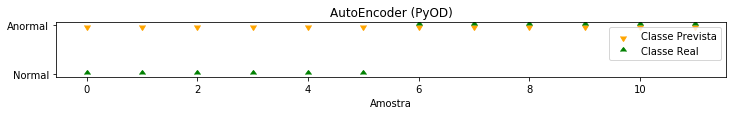

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 1 1 1 1 1 1]


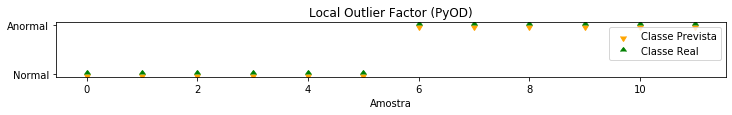

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 0 0 0 1 1 0 0 0]


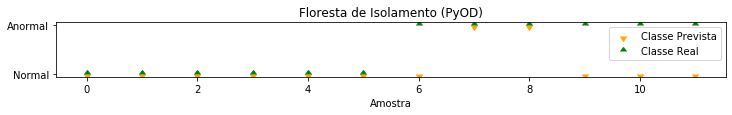

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


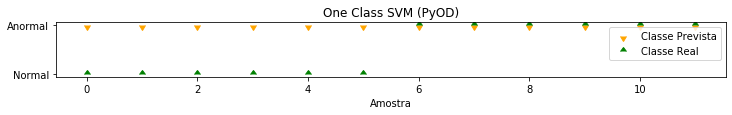

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


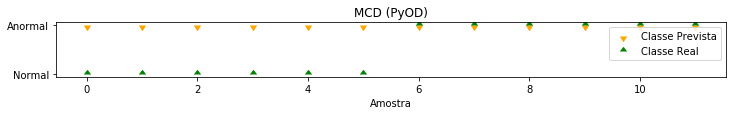

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


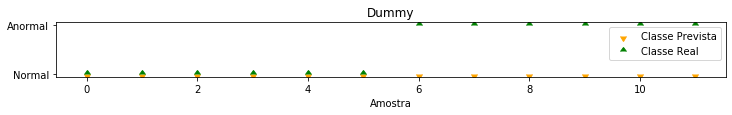

Instância 8: data\2\WELL-00003_20170728150240.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 18)                342       
_________________________________________________________________
dropout_31 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 18)                342       
_________________________________________________________________
dropout_32 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 8)                 152       
_________________________________________________________________
dropout_33 (Dropout)         (None, 8)                 0         
_________

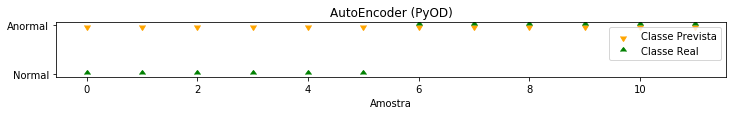

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 1 0 0 1 1 1 1 1 1 1 1]


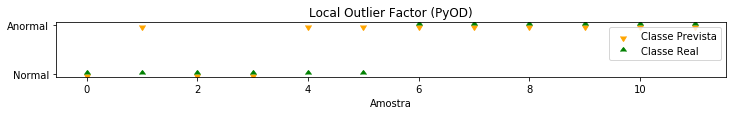

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 1 0 0 0 0 1 1 1 1 1 1]


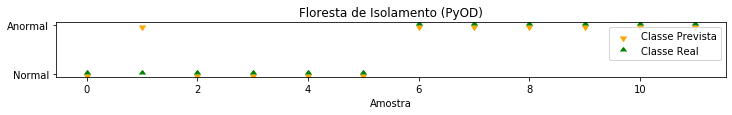

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


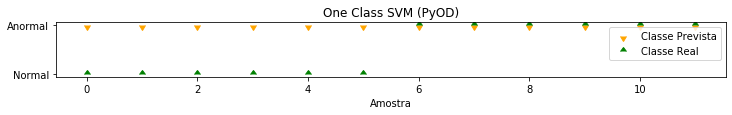

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[0 1 1 1 1 1 1 1 1 1 1 1]


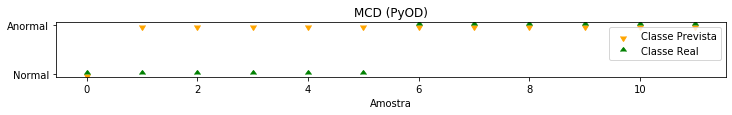

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


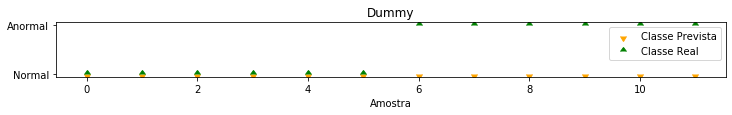

Instância 9: data\2\WELL-00003_20180206182917.csv
	ignorado porque normal_period_size é insuficiente para treinamento (586)

Instância 10: data\2\WELL-00009_20170313160804.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 30)                930       
_________________________________________________________________
dropout_37 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 30)                930       
_________________________________________________________________
dropout_38 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 8)                 248       
_______________

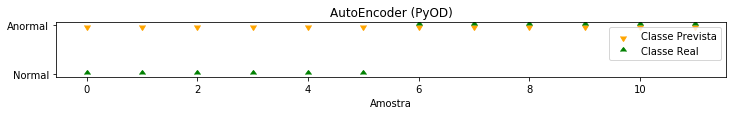

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 1 1 1 1 1 1]


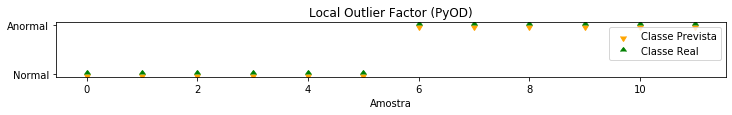

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 0 0 1 1 1 1 1 1]


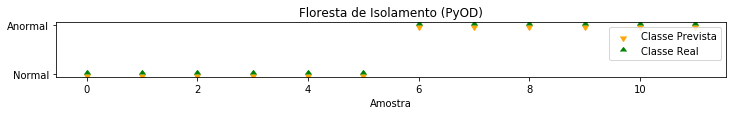

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


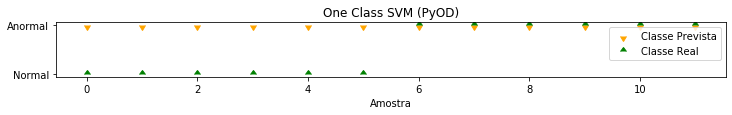

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


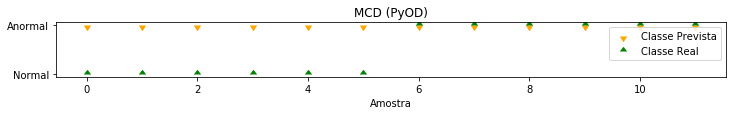

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


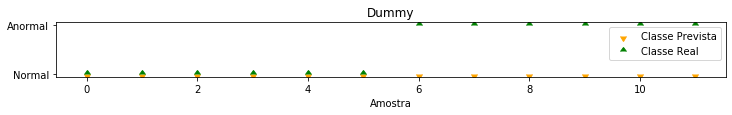

Instância 11: data\2\WELL-00010_20171218200131.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 36)                1332      
_________________________________________________________________
dropout_43 (Dropout)         (None, 36)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 36)                1332      
_________________________________________________________________
dropout_44 (Dropout)         (None, 36)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 8)                 296       
_________________________________________________________________
dropout_45 (Dropout)         (None, 8)                 0         
________

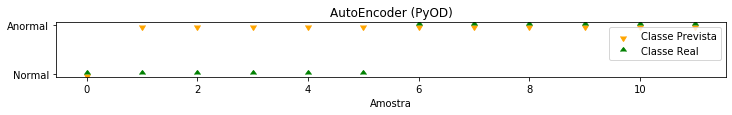

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 1 1 1 1 1 1 1]


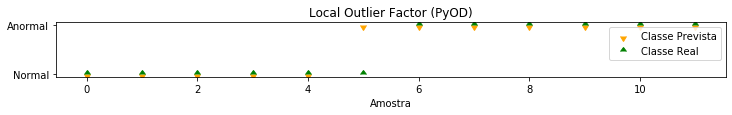

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 1 0 1 1 1 1 1 1 1 1]


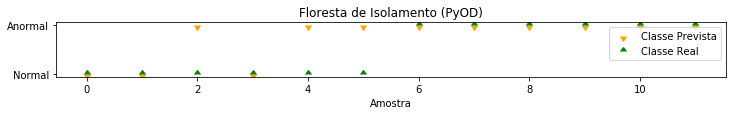

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


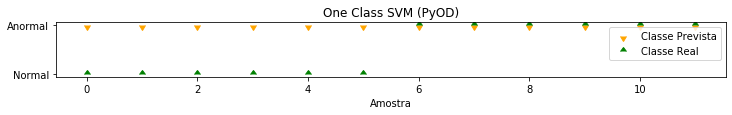

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[0 0 0 1 1 1 1 1 1 1 1 1]


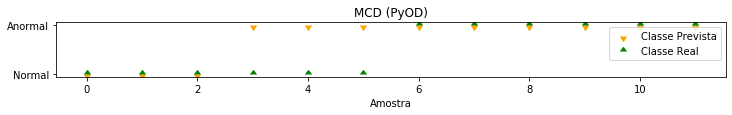

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


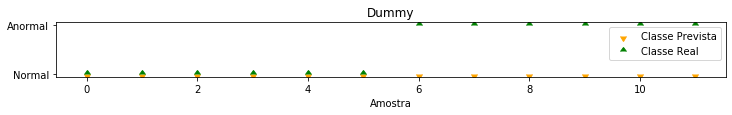

Instância 12: data\2\WELL-00011_20140515110134.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_49 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_50 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 8)                 104       
_________________________________________________________________
dropout_51 (Dropout)         (None, 8)                 0         
________

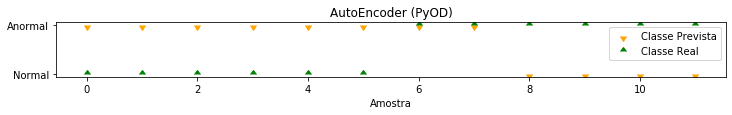

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 0 0 0 0 0 0]


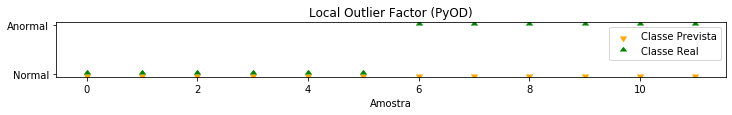

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 0 0 0 0 0 0 0 0]


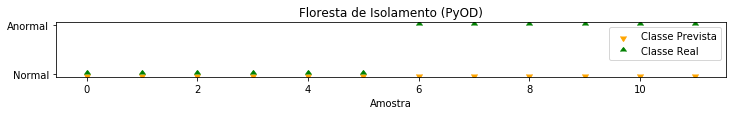

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 0 0 0 0]


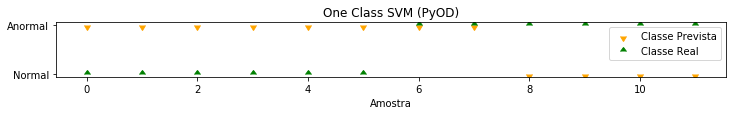

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[0 0 0 0 0 0 0 0 0 0 0 0]


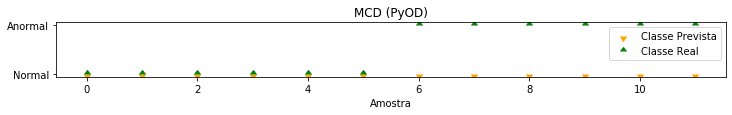

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


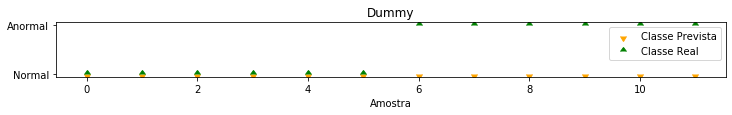

Instância 13: data\2\WELL-00011_20140530100015.csv
	ignorado porque normal_period_size é insuficiente para treinamento (482)

Instância 14: data\2\WELL-00011_20140606230115.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 18)                342       
_________________________________________________________________
dropout_55 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 18)                342       
_________________________________________________________________
dropout_56 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 8)                 152       
_____________

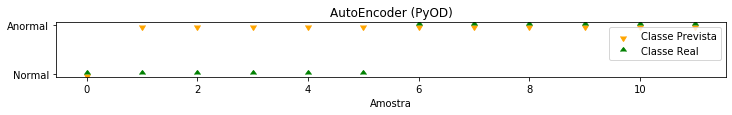

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 1 1 1 1 1 1]


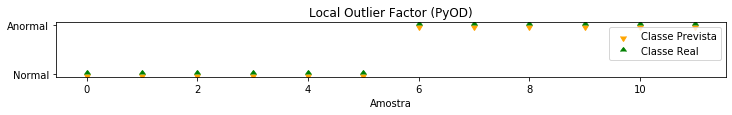

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 0 0 1 1 1 0 0 0]


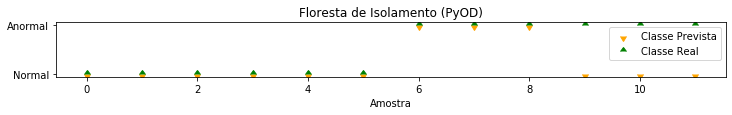

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[0 1 1 1 1 1 1 1 1 1 1 1]


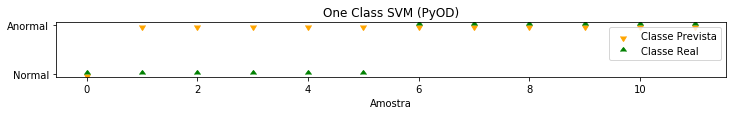

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[0 0 1 1 1 1 1 1 1 1 1 1]


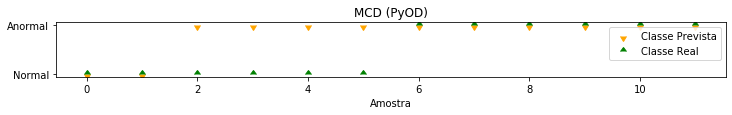

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


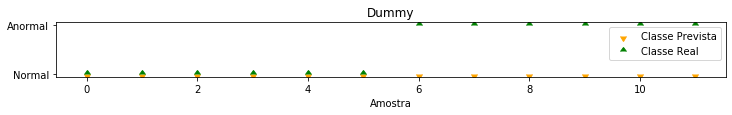

Instância 15: data\2\WELL-00011_20140720120102.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_61 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_72 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_62 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_73 (Dense)             (None, 8)                 56        
_________________________________________________________________
dropout_63 (Dropout)         (None, 8)                 0         
_______

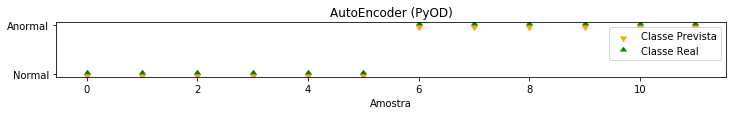

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 1 1 1 1 1 1]


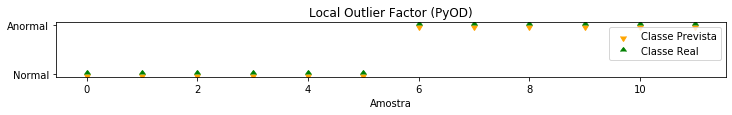

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 0 0 0 1 1 1 1 1]


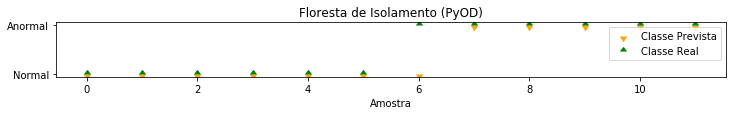

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[0 0 0 0 0 0 1 1 1 1 1 1]


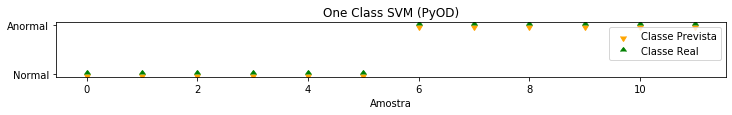

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[1 1 1 1 0 1 1 1 1 1 1 1]


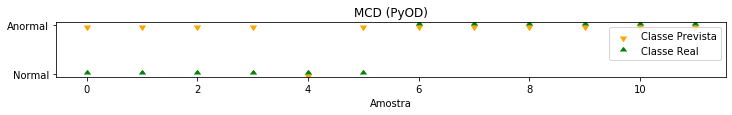

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


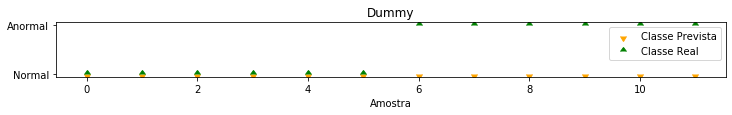

Instância 16: data\2\WELL-00011_20140726180015.csv
	ignorado porque normal_period_size é insuficiente para treinamento (900)

Instância 17: data\2\WELL-00011_20140824000118.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 18)                342       
_________________________________________________________________
dropout_67 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 18)                342       
_________________________________________________________________
dropout_68 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_80 (Dense)             (None, 8)                 152       
_____________

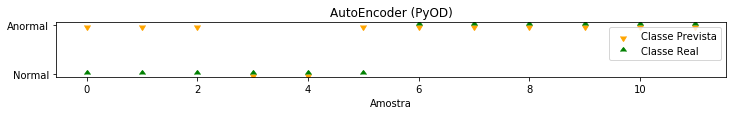

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 1 1 1 1 1 1]


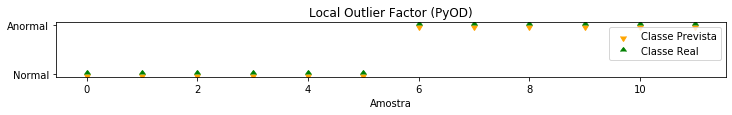

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 0 1 1 1 1 1 1 0]


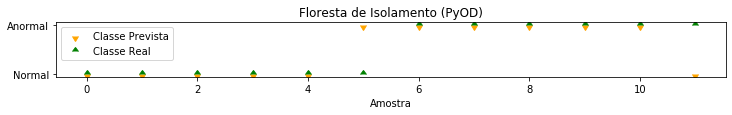

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 0 1 1 1 1 1 1 1]


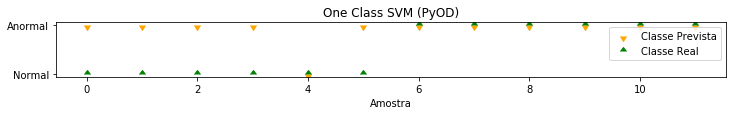

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[0 1 0 0 0 0 1 1 1 1 1 1]


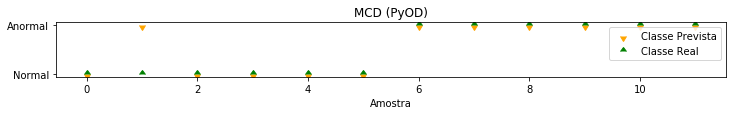

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


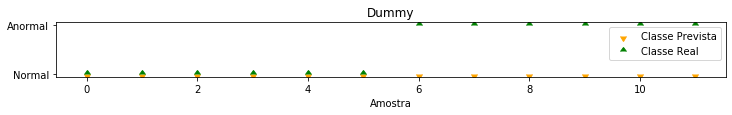

Instância 18: data\2\WELL-00011_20140916060300.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 18)                342       
_________________________________________________________________
dropout_73 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 18)                342       
_________________________________________________________________
dropout_74 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_87 (Dense)             (None, 8)                 152       
_________________________________________________________________
dropout_75 (Dropout)         (None, 8)                 0         
_______

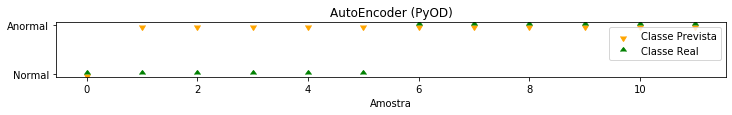

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 0 1 1 1 1 1]


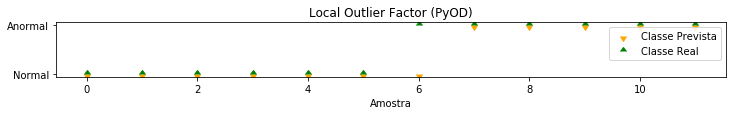

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 1 0 0 0 0 0 1 1 1 1 1]


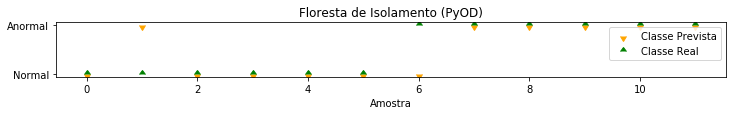

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[0 0 0 0 0 1 1 1 1 1 1 1]


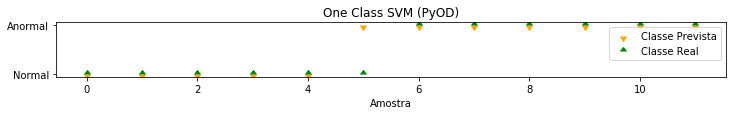

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[0 0 0 1 0 0 0 1 1 1 1 1]


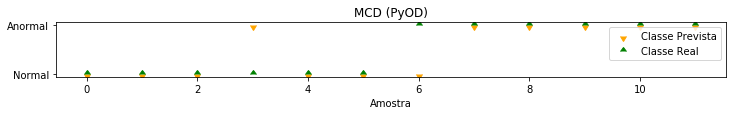

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


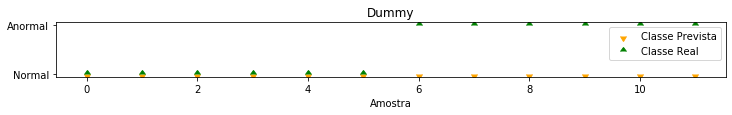

Instância 19: data\2\WELL-00011_20140921200031.csv
	ignorado porque normal_period_size é insuficiente para treinamento (695)

Instância 20: data\2\WELL-00011_20140928100056.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 18)                342       
_________________________________________________________________
dropout_79 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_93 (Dense)             (None, 18)                342       
_________________________________________________________________
dropout_80 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_94 (Dense)             (None, 8)                 152       
_____________

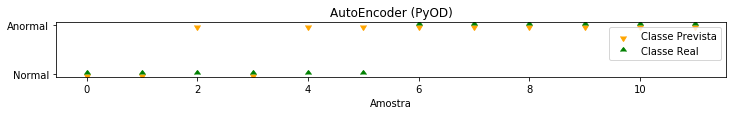

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 1 1 1 1 1 1]


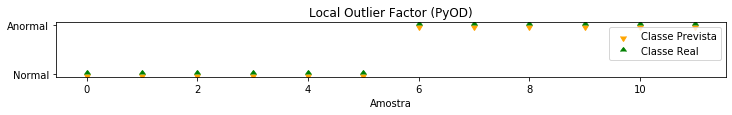

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 0 0 1 1 1 1 1 1]


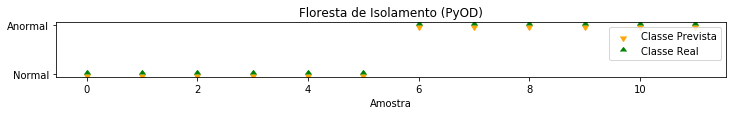

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[0 0 0 0 1 1 1 1 1 1 1 1]


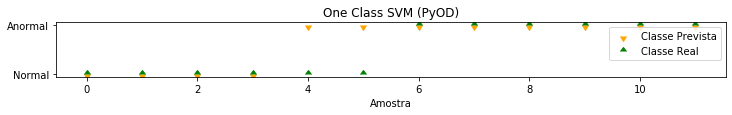

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[0 1 1 0 1 1 1 1 1 1 1 1]


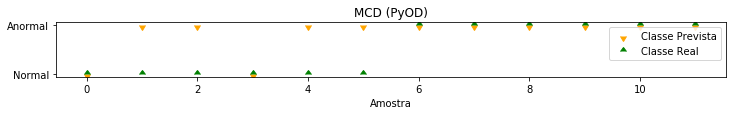

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


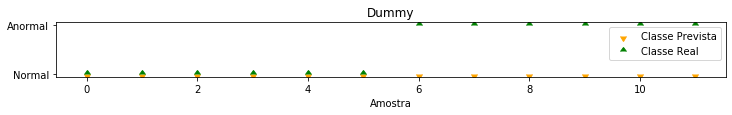

Instância 21: data\2\WELL-00011_20140929170028.csv
	ignorado porque normal_period_size é insuficiente para treinamento (975)

Instância 22: data\2\WELL-00011_20140929220121.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 18)                342       
_________________________________________________________________
dropout_85 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 18)                342       
_________________________________________________________________
dropout_86 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 8)                 152       
_____________

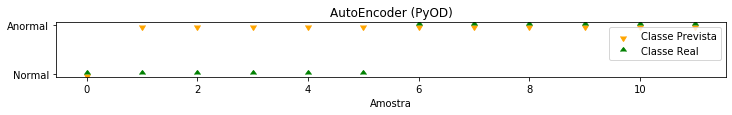

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 0 1 1 1 1 1]


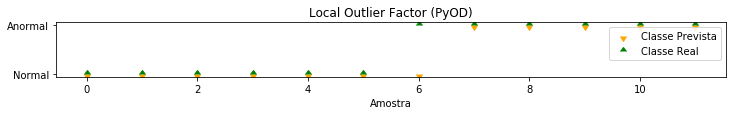

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 0 0 0 1 1 1 1 1]


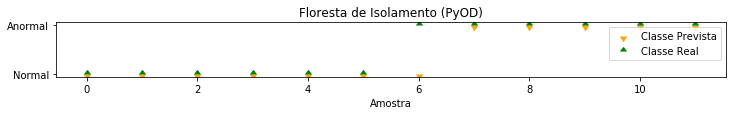

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


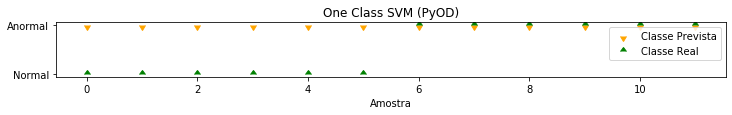

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[0 1 1 1 0 0 0 1 1 1 1 1]


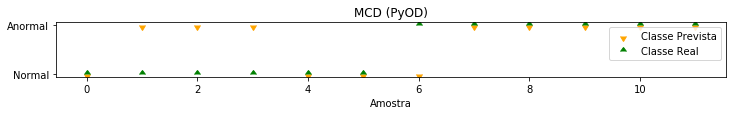

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


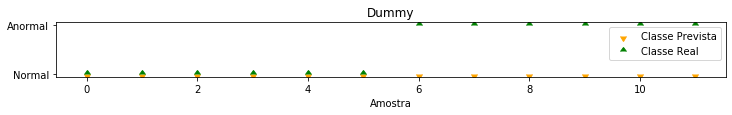

Instância 23: data\2\WELL-00011_20141005170056.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 12)                156       
_________________________________________________________________
dropout_91 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_107 (Dense)            (None, 12)                156       
_________________________________________________________________
dropout_92 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_108 (Dense)            (None, 8)                 104       
_________________________________________________________________
dropout_93 (Dropout)         (None, 8)                 0         
_______

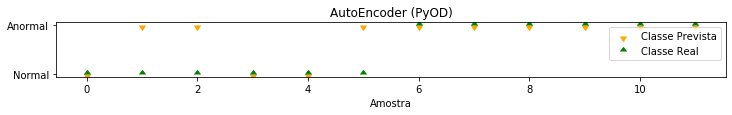

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 1 1 1 1 1 1]


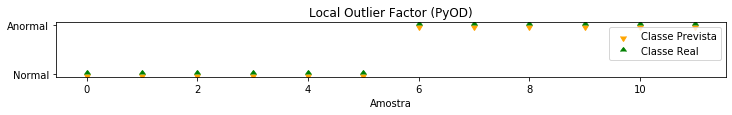

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 0 1 1 1 1 1 1 1]


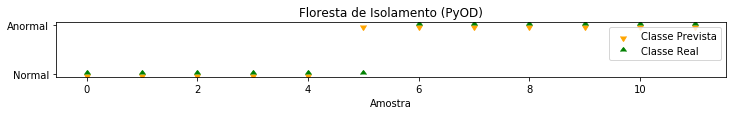

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[0 1 0 0 0 1 1 1 1 1 1 1]


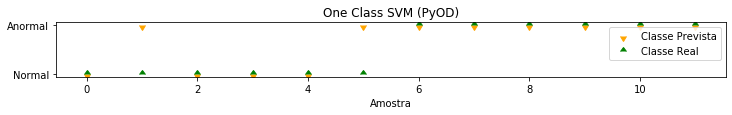

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[0 0 0 0 1 0 1 1 1 1 1 1]


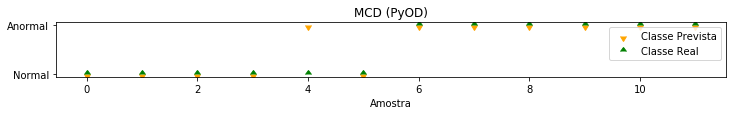

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


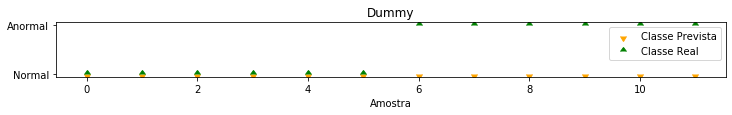

Instância 24: data\2\WELL-00011_20141006160121.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_113 (Dense)            (None, 18)                342       
_________________________________________________________________
dropout_97 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_114 (Dense)            (None, 18)                342       
_________________________________________________________________
dropout_98 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_115 (Dense)            (None, 8)                 152       
_________________________________________________________________
dropout_99 (Dropout)         (None, 8)                 0         
_______

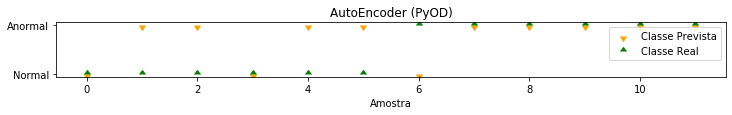

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 0 1 1 1 1 1]


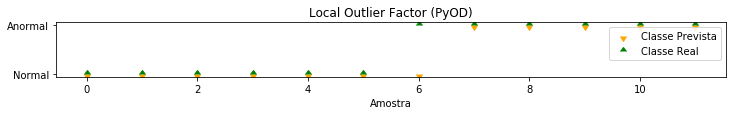

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 0 0 0 1 1 1 1 1]


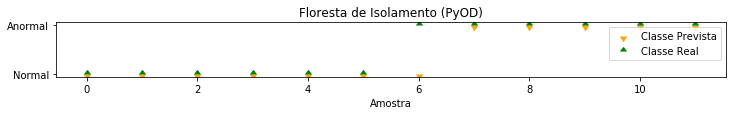

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[0 1 0 0 0 0 0 1 1 1 1 1]


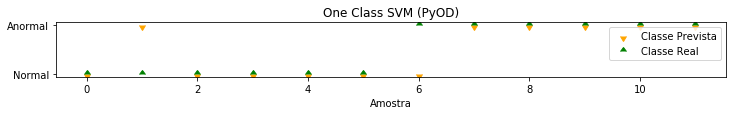

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[0 0 0 0 0 0 0 1 1 1 1 1]


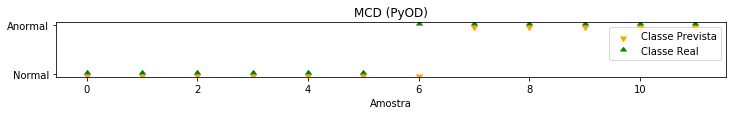

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


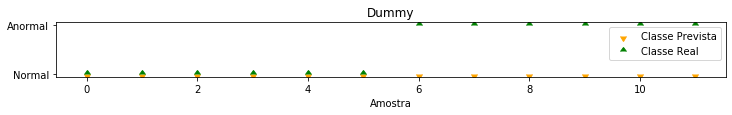

Instância 25: data\2\WELL-00012_20170320033022.csv
	ignorado porque normal_period_size é insuficiente para treinamento (773)

Instância 26: data\2\WELL-00012_20170320143144.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_120 (Dense)            (None, 24)                600       
_________________________________________________________________
dropout_103 (Dropout)        (None, 24)                0         
_________________________________________________________________
dense_121 (Dense)            (None, 24)                600       
_________________________________________________________________
dropout_104 (Dropout)        (None, 24)                0         
_________________________________________________________________
dense_122 (Dense)            (None, 8)                 200       
_____________

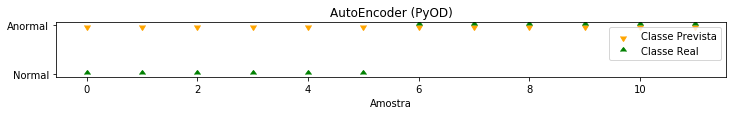

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 1 1 1 1 1 1 1 1 1 1]


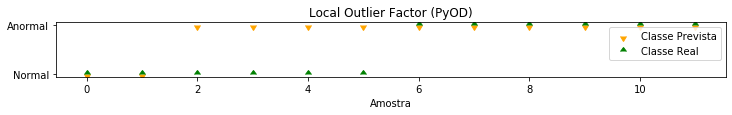

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 0 0 0 0 1 1 1 1]


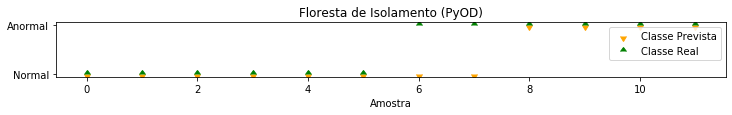

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


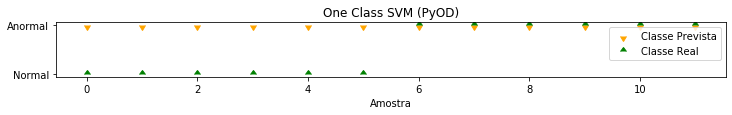

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


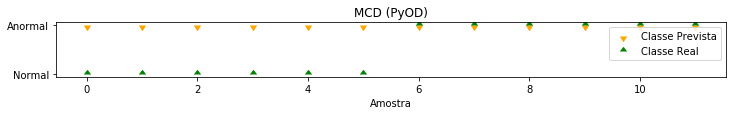

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


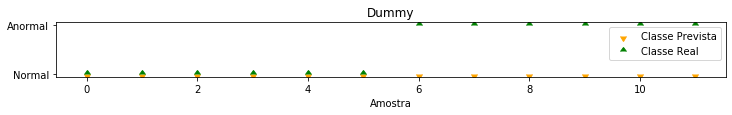

Instância 27: data\2\WELL-00013_20170329020229.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_127 (Dense)            (None, 6)                 42        
_________________________________________________________________
dropout_109 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_128 (Dense)            (None, 6)                 42        
_________________________________________________________________
dropout_110 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_129 (Dense)            (None, 8)                 56        
_________________________________________________________________
dropout_111 (Dropout)        (None, 8)                 0         
_______

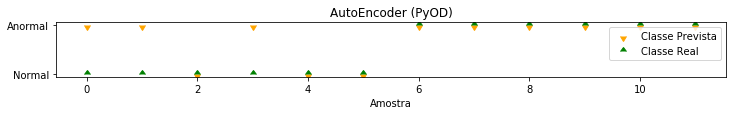

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 0 1 1 1 1 1]


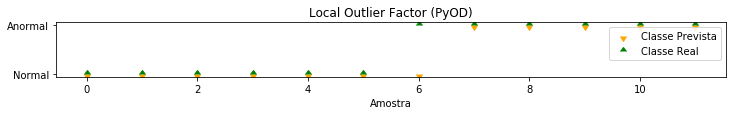

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 0 0 0 1 1 1 1 1]


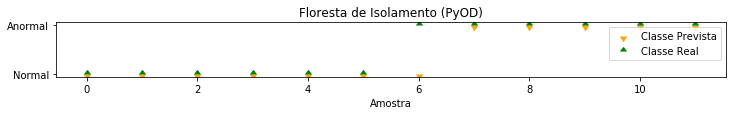

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[0 0 0 1 0 0 1 1 1 1 1 1]


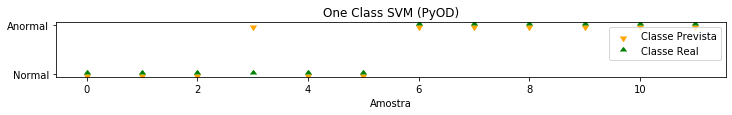

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[0 0 0 0 0 0 0 1 1 1 1 1]


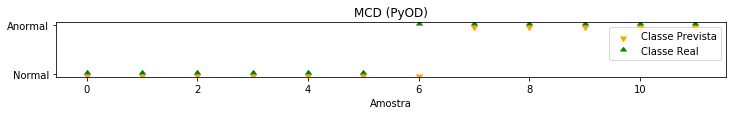

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


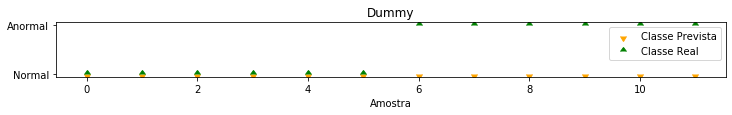

Instância 28: data\5\WELL-00015_20170620160349.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_134 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_115 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_135 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_116 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_136 (Dense)            (None, 8)                 248       
_________________________________________________________________
dropout_117 (Dropout)        (None, 8)                 0         
_______

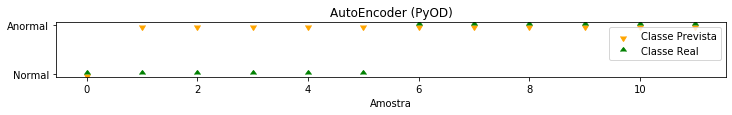

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 1 0 1 1 1 1 1]


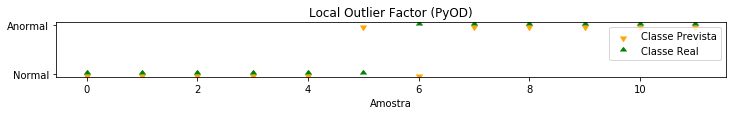

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 1 1 1 1 1 1 1 1]


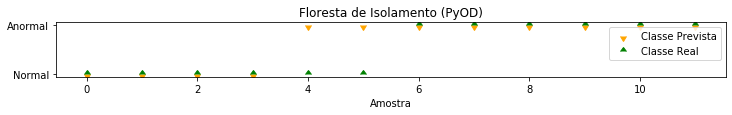

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


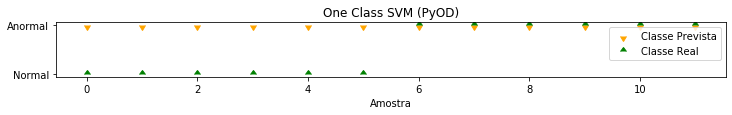

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[0 0 0 0 1 1 1 1 1 1 1 1]


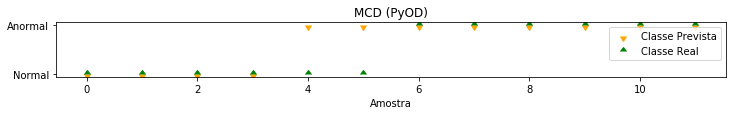

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


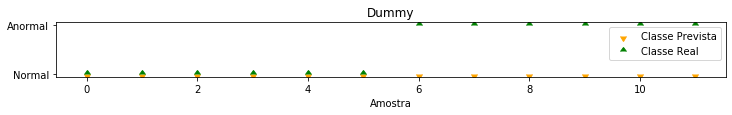

Instância 29: data\5\WELL-00015_20171013140047.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_141 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_121 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_142 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_122 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_143 (Dense)            (None, 8)                 248       
_________________________________________________________________
dropout_123 (Dropout)        (None, 8)                 0         
_______

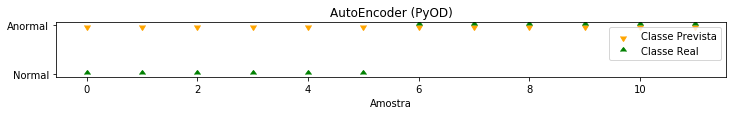

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 0 1 1 1 1 1]


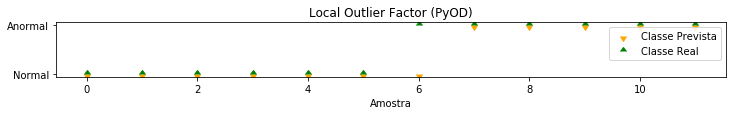

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 0 0 0 1 0 1 1 1]


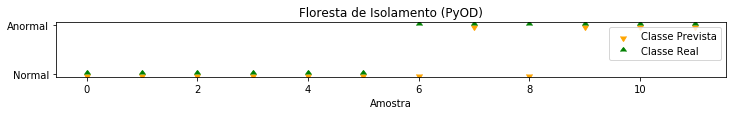

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


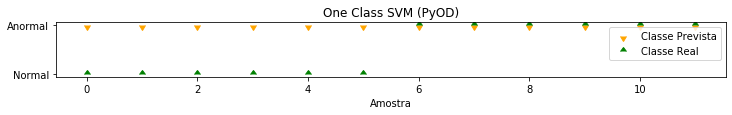

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


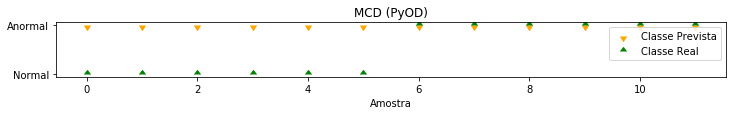

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


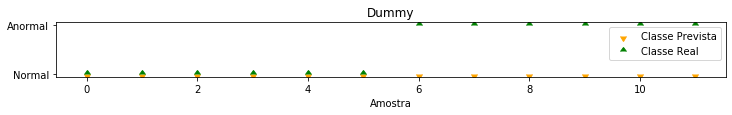

Instância 30: data\5\WELL-00016_20180405020345.csv
	ignorado porque normal_period_size é insuficiente para treinamento (1145)

Instância 31: data\5\WELL-00016_20180426142005.csv
	ignorado porque normal_period_size é insuficiente para treinamento (321)

Instância 32: data\5\WELL-00016_20180426145108.csv
	ignorado porque normal_period_size é insuficiente para treinamento (376)

Instância 33: data\5\WELL-00016_20180517222322.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_148 (Dense)            (None, 42)                1806      
_________________________________________________________________
dropout_127 (Dropout)        (None, 42)                0         
_________________________________________________________________
dense_149 (Dense)            (None, 42)                1806      
________________________

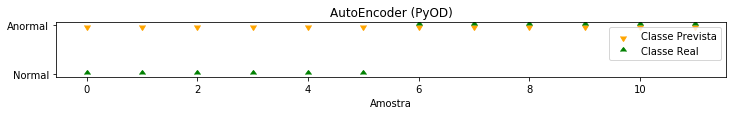

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 1 1 1 1 1 1 1 1 1 1 1]


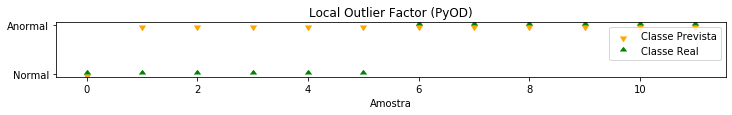

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[1 0 0 0 0 0 0 1 0 0 0 1]


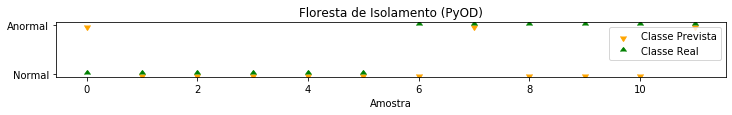

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


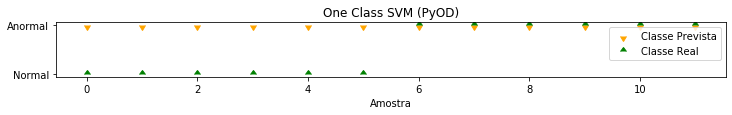

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


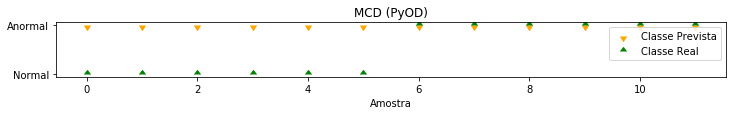

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


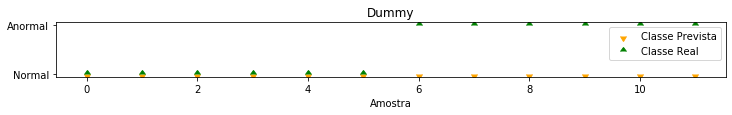

Instância 34: data\5\WELL-00017_20140314180000.csv
	ignorado porque normal_period_size é insuficiente para treinamento (0)

Instância 35: data\5\WELL-00017_20140317151743.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_155 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_133 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_156 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_134 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_157 (Dense)            (None, 8)                 248       
_______________

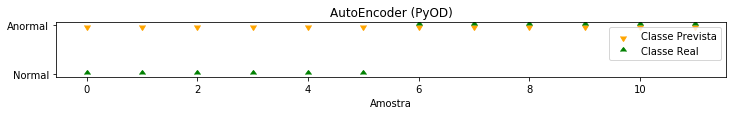

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 0 1 1 1 1 1]


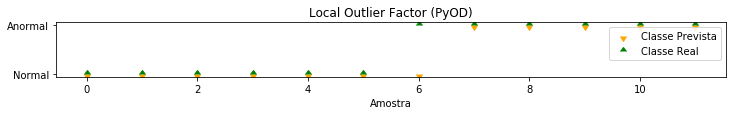

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[1 1 0 1 1 1 1 0 1 1 1 1]


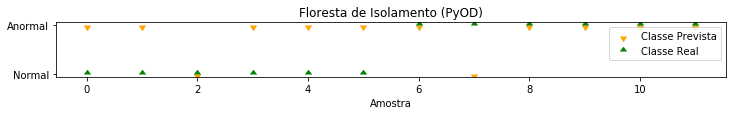

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


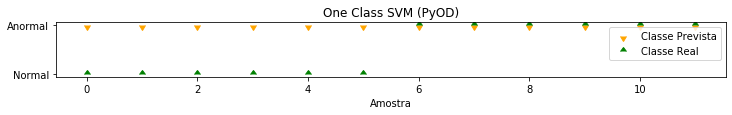

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[0 0 1 1 0 0 1 1 1 1 1 1]


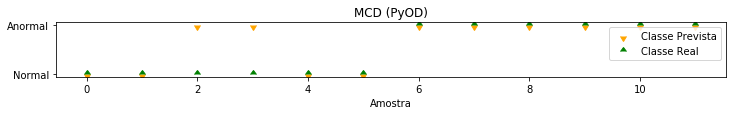

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


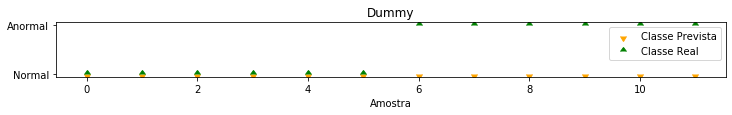

Instância 36: data\5\WELL-00017_20140318023141.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_162 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_139 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_163 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_140 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_164 (Dense)            (None, 8)                 248       
_________________________________________________________________
dropout_141 (Dropout)        (None, 8)                 0         
_______

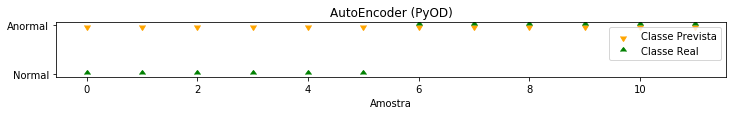

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 1 1 1 1 1 1]


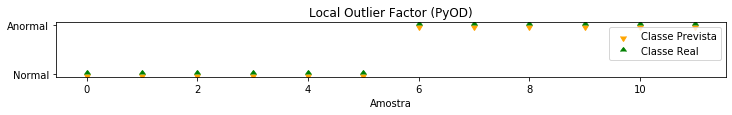

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 1 1 0 1 1 1 1 1 1]


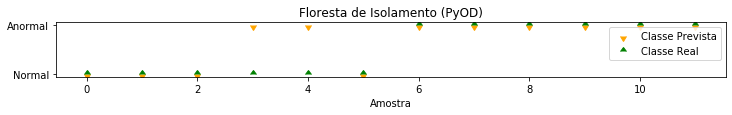

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


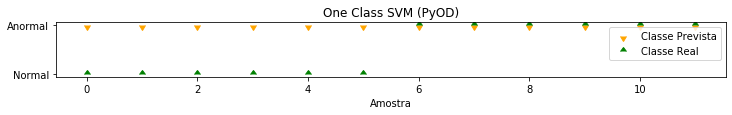

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[1 0 0 1 0 0 1 1 1 1 1 1]


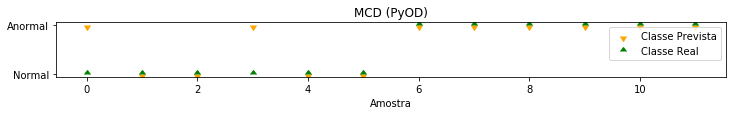

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


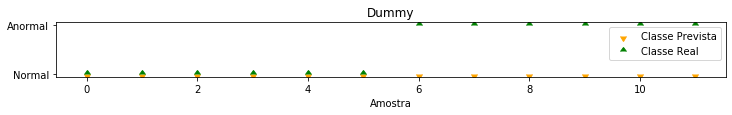

Instância 37: data\5\WELL-00017_20140318160220.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_169 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_145 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_170 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_146 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_171 (Dense)            (None, 8)                 248       
_________________________________________________________________
dropout_147 (Dropout)        (None, 8)                 0         
_______

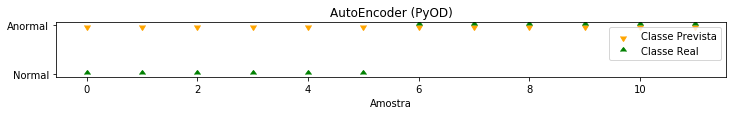

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 0 1 1 1 1 1]


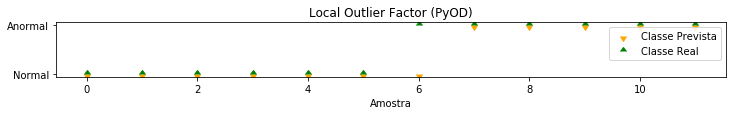

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 1 0 1 1 1 1 1 1 1 1]


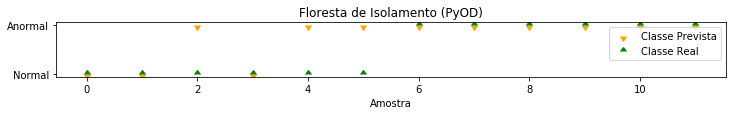

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


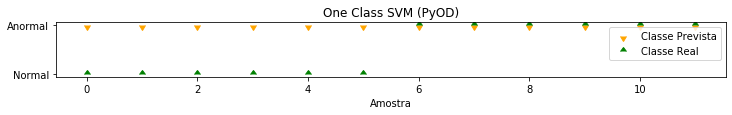

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[0 0 0 1 0 1 1 1 1 1 1 1]


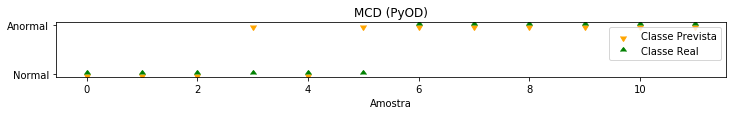

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


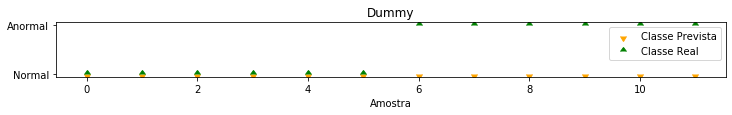

Instância 38: data\5\WELL-00017_20140319040453.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_176 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_151 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_177 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_152 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_178 (Dense)            (None, 8)                 248       
_________________________________________________________________
dropout_153 (Dropout)        (None, 8)                 0         
_______

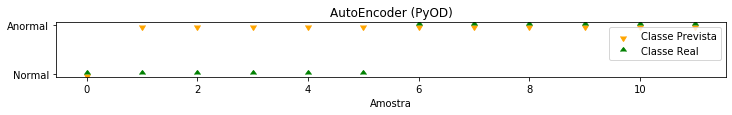

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 0 1 1 1 1 1]


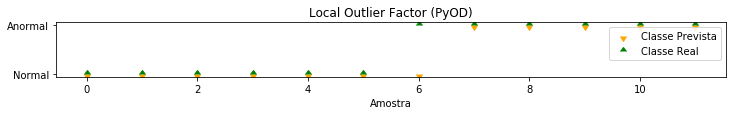

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


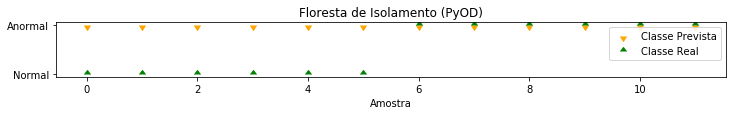

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


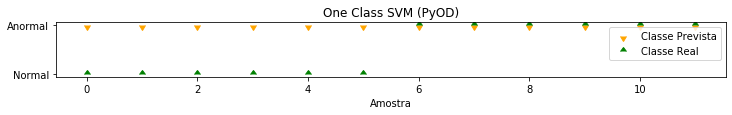

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[0 0 0 1 1 1 1 1 1 1 1 1]


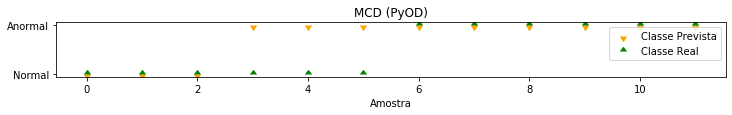

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


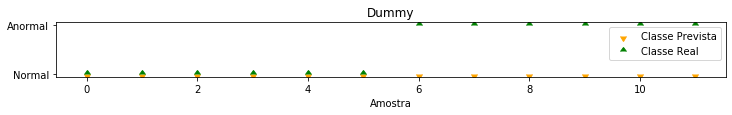

Instância 39: data\5\WELL-00017_20140319141450.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_183 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_157 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_184 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_158 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_185 (Dense)            (None, 8)                 248       
_________________________________________________________________
dropout_159 (Dropout)        (None, 8)                 0         
_______

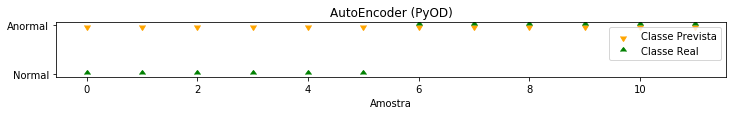

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 1 1 1 1 1 1 1 1 1 1]


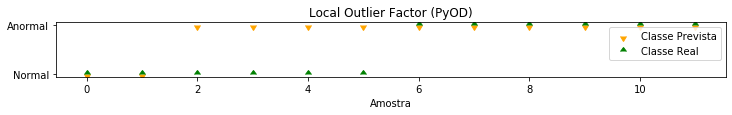

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 1 0 0 0 0 1 1 1 1 1]


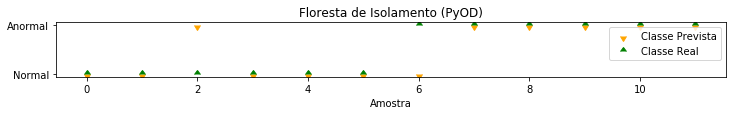

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


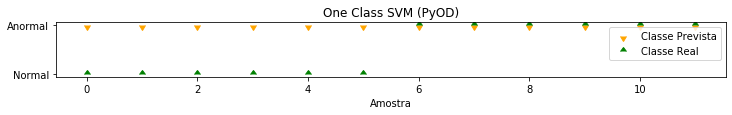

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[1 0 0 1 1 1 1 1 1 1 1 1]


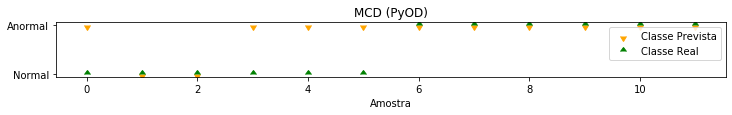

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


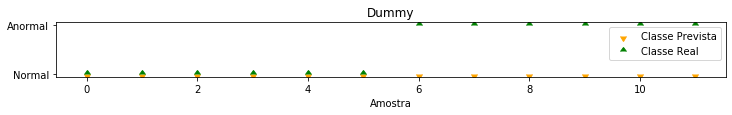

Instância 40: data\6\WELL-00002_20140212170333.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_190 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_163 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_191 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_164 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_192 (Dense)            (None, 8)                 248       
_________________________________________________________________
dropout_165 (Dropout)        (None, 8)                 0         
_______

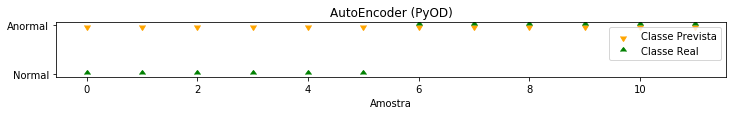

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 1 1 0 0 1 1 1]


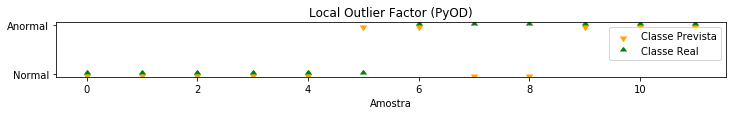

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 0 1 1 0 0 0 0 0]


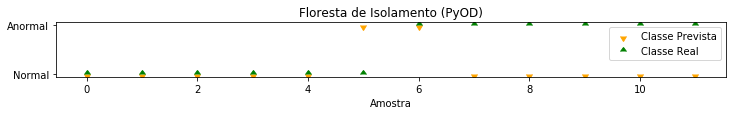

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


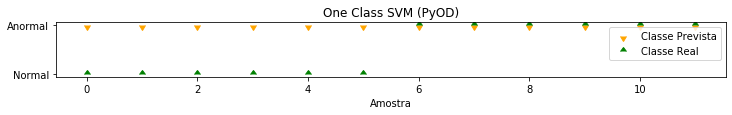

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[0 0 0 0 1 1 1 0 0 1 1 1]


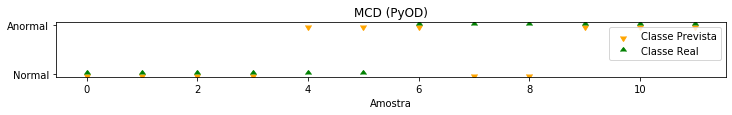

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


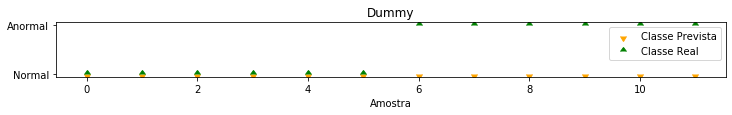

Instância 41: data\6\WELL-00002_20140301151700.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_197 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_169 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_198 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_170 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_199 (Dense)            (None, 8)                 248       
_________________________________________________________________
dropout_171 (Dropout)        (None, 8)                 0         
_______

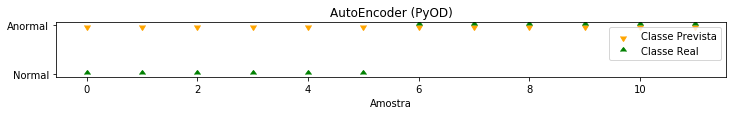

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 1 1 1 1 1 1]


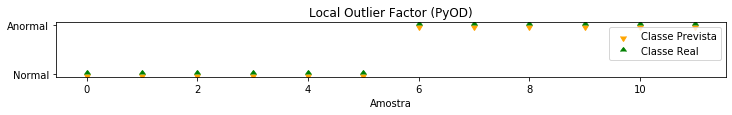

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 0 1 1 1 1 1 1 1]


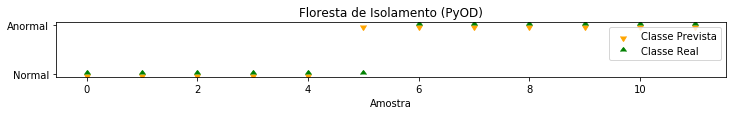

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


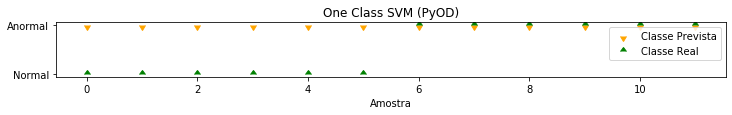

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[0 1 1 1 1 1 1 1 1 1 1 1]


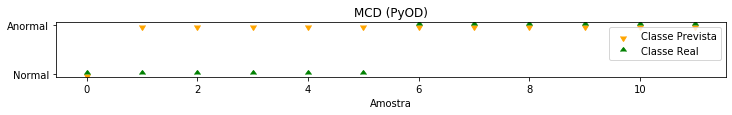

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


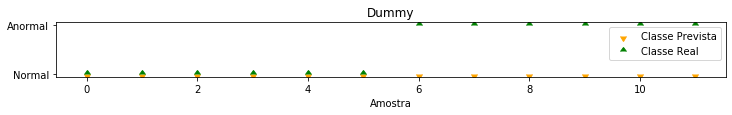

Instância 42: data\6\WELL-00002_20140325170304.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_204 (Dense)            (None, 24)                600       
_________________________________________________________________
dropout_175 (Dropout)        (None, 24)                0         
_________________________________________________________________
dense_205 (Dense)            (None, 24)                600       
_________________________________________________________________
dropout_176 (Dropout)        (None, 24)                0         
_________________________________________________________________
dense_206 (Dense)            (None, 8)                 200       
_________________________________________________________________
dropout_177 (Dropout)        (None, 8)                 0         
_______

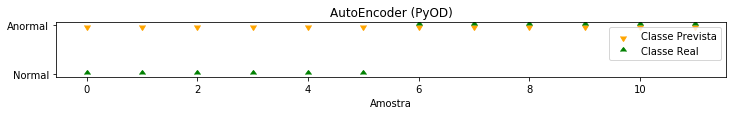

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 1 1 1 1 1 1 1]


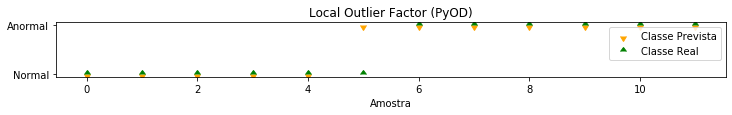

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 0 1 0 0 0 1 1 1]


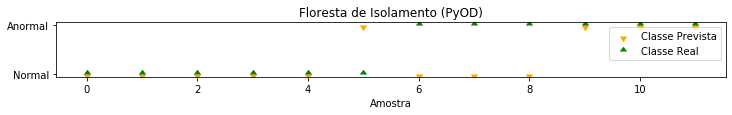

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


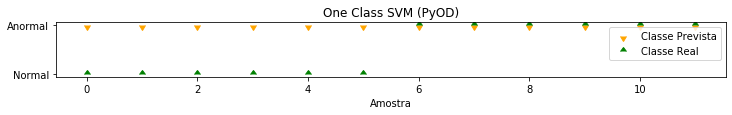

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[0 0 0 0 0 1 1 1 0 1 1 1]


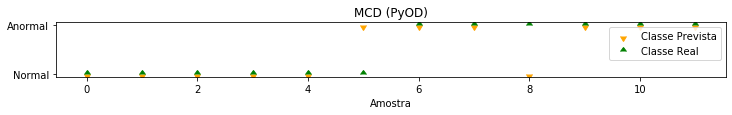

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


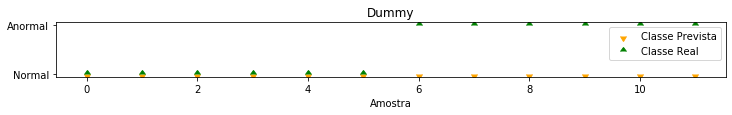

Instância 43: data\6\WELL-00004_20171031181509.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_211 (Dense)            (None, 12)                156       
_________________________________________________________________
dropout_181 (Dropout)        (None, 12)                0         
_________________________________________________________________
dense_212 (Dense)            (None, 12)                156       
_________________________________________________________________
dropout_182 (Dropout)        (None, 12)                0         
_________________________________________________________________
dense_213 (Dense)            (None, 8)                 104       
_________________________________________________________________
dropout_183 (Dropout)        (None, 8)                 0         
_______

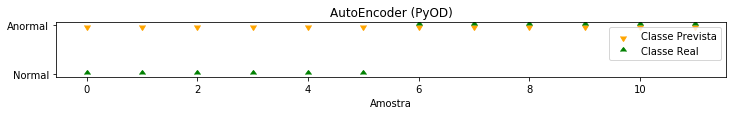

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 1 0 0 0 0 1 1 1 1 1]


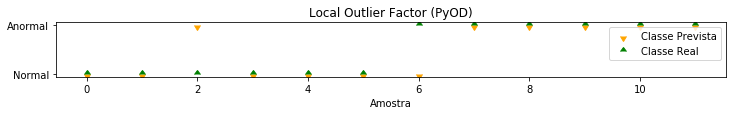

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 0 0 0 0 0 0 0 0]


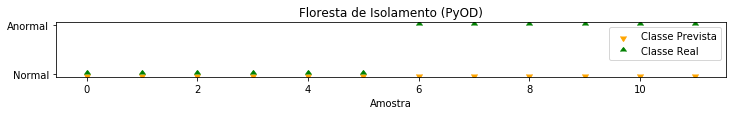

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


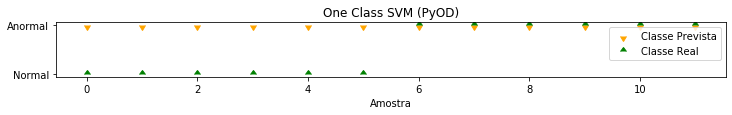

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


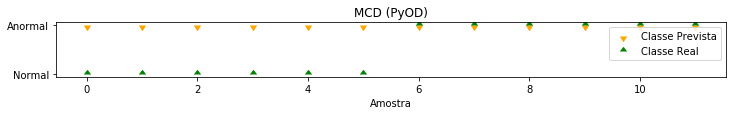

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


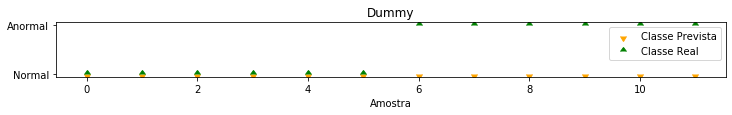

Instância 44: data\6\WELL-00004_20171031193025.csv
	ignorado porque normal_period_size é insuficiente para treinamento (414)

Instância 45: data\6\WELL-00004_20171031200059.csv
	ignorado porque normal_period_size é insuficiente para treinamento (845)

Instância 46: data\7\WELL-00001_20170226220309.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_218 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_187 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_219 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_188 (Dropout)        (None, 30)                0         
___________________

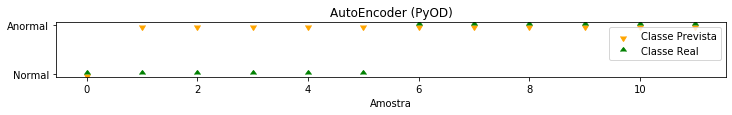

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 0 1 1 1 1 1]


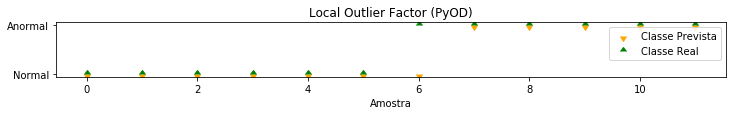

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 1 0 0 0 0 0 1 1 1 1]


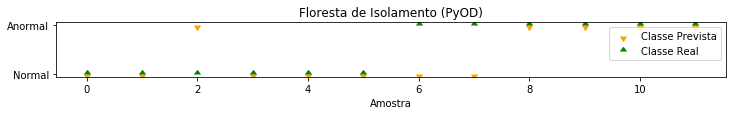

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[0 1 1 1 1 1 1 1 1 1 1 1]


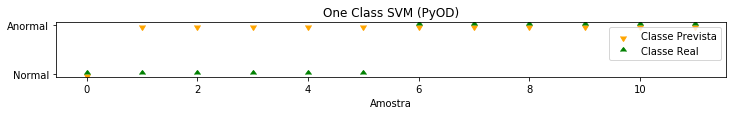

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


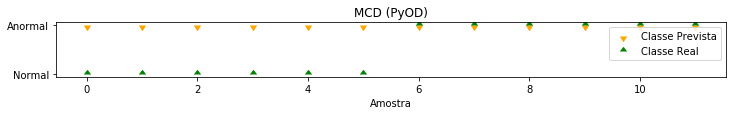

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


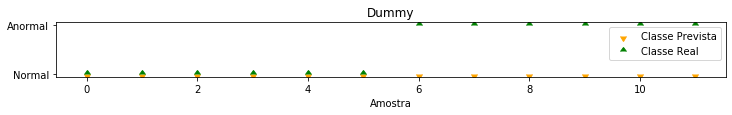

Instância 47: data\7\WELL-00006_20180618110721.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_225 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_193 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_226 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_194 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_227 (Dense)            (None, 8)                 248       
_________________________________________________________________
dropout_195 (Dropout)        (None, 8)                 0         
_______

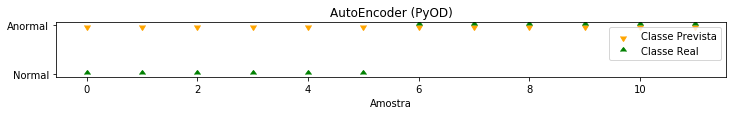

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 0 1 1 1 1 1]


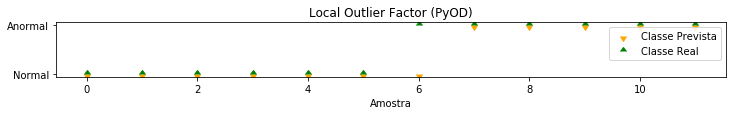

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 1 1 0 0 1 1 1 1 1]


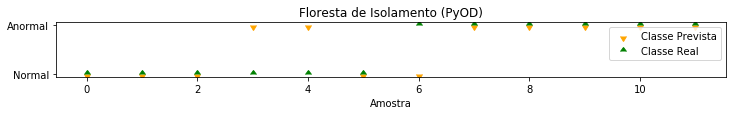

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


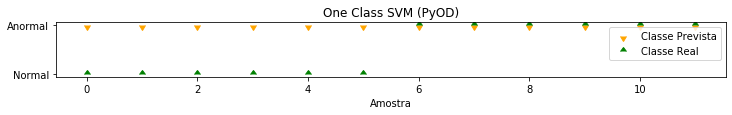

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


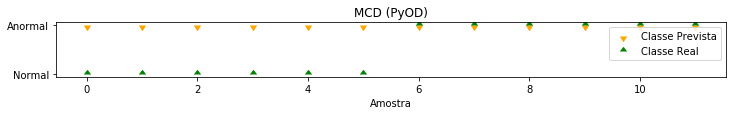

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


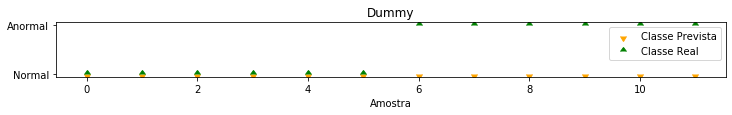

Instância 48: data\7\WELL-00006_20180620181348.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_232 (Dense)            (None, 36)                1332      
_________________________________________________________________
dropout_199 (Dropout)        (None, 36)                0         
_________________________________________________________________
dense_233 (Dense)            (None, 36)                1332      
_________________________________________________________________
dropout_200 (Dropout)        (None, 36)                0         
_________________________________________________________________
dense_234 (Dense)            (None, 8)                 296       
_________________________________________________________________
dropout_201 (Dropout)        (None, 8)                 0         
_______

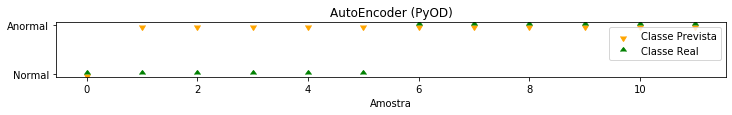

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 0 0 1 1 1 1 1]


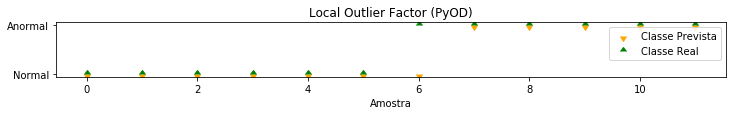

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 0 0 0 1 1 1 1 1]


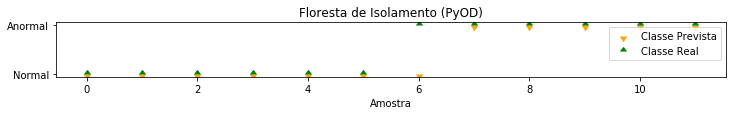

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


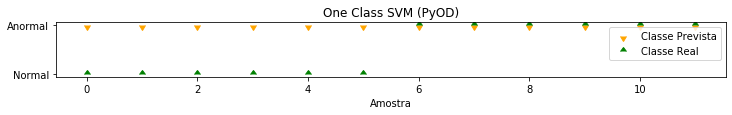

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[0 0 0 0 0 0 0 1 1 1 1 1]


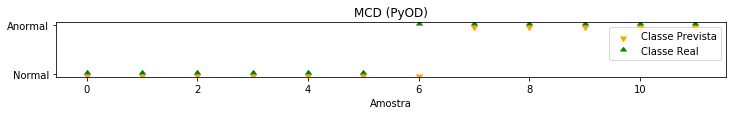

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


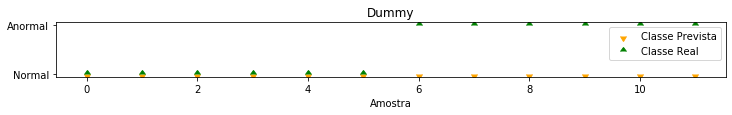

Instância 49: data\7\WELL-00018_20180611040207.csv
	ignorado porque normal_period_size é insuficiente para treinamento (0)

Instância 50: data\8\WELL-00019_20170301182317.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_239 (Dense)            (None, 12)                156       
_________________________________________________________________
dropout_205 (Dropout)        (None, 12)                0         
_________________________________________________________________
dense_240 (Dense)            (None, 12)                156       
_________________________________________________________________
dropout_206 (Dropout)        (None, 12)                0         
_________________________________________________________________
dense_241 (Dense)            (None, 8)                 104       
_______________

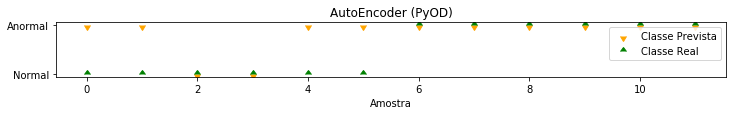

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 0 0 1 1 1 1 1 1 1]


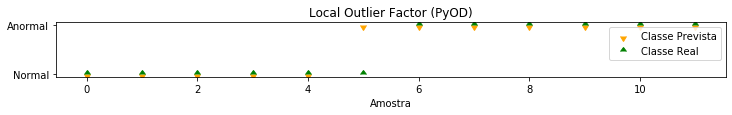

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[1 1 0 0 0 0 0 0 0 0 0 0]


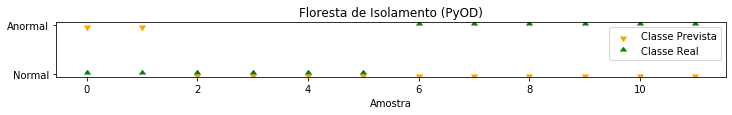

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 0 0 1 1 1 1 1 1 1 1]


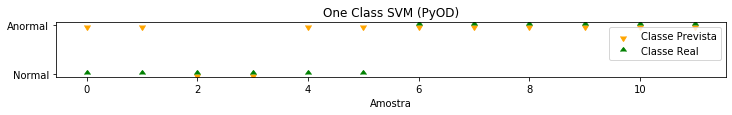

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[1 1 0 1 1 1 1 1 1 1 1 1]


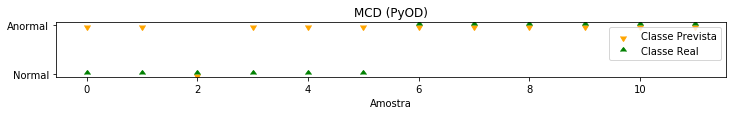

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


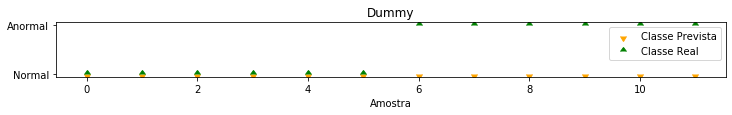

Instância 51: data\8\WELL-00020_20120410192326.csv
	ignorado porque normal_period_size é insuficiente para treinamento (173)

Instância 52: data\8\WELL-00021_20170509013517.csv
y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_246 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_211 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_247 (Dense)            (None, 30)                930       
_________________________________________________________________
dropout_212 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_248 (Dense)            (None, 8)                 248       
_____________

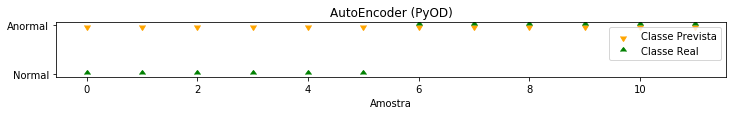

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Local Outlier Factor (PyOD)
[0 0 0 1 1 1 1 1 1 1 1 1]


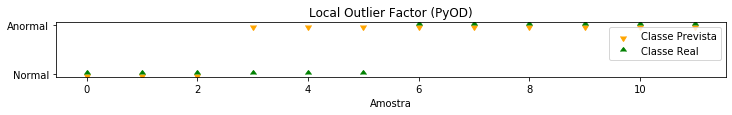

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Floresta de Isolamento (PyOD)
[0 0 0 0 0 1 1 1 1 1 1 1]


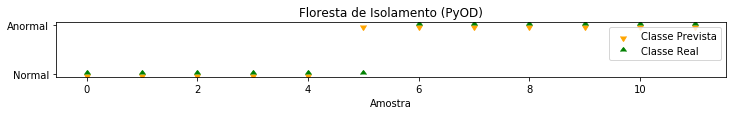

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - One Class SVM (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


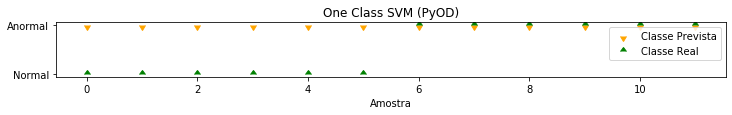

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - MCD (PyOD)
[1 1 1 1 1 1 1 1 1 1 1 1]


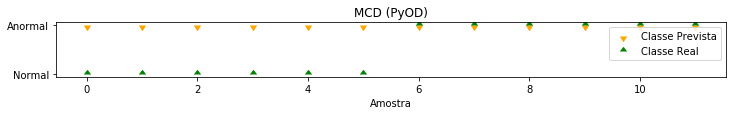

y_train
[0 0 0 0 0 0 0 0 0]
y_test
[0 0 0 0 0 0 1 1 1 1 1 1]
y_pred - Dummy
[0 0 0 0 0 0 0 0 0 0 0 0]


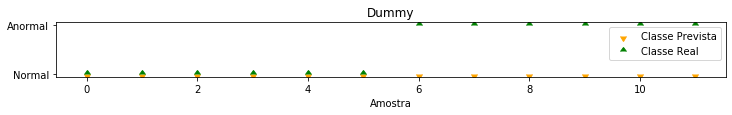

In [11]:
# For each real instance with any type of undesirable event
scores = pd.DataFrame()
ignored_instances = 0
used_instances = 0
for i, row in real_instances.iterrows():
    # Loads the current instance
    class_code, instance_path = row
    print(f'Instância {i+1}: {instance_path}')
    df = load_instance(instance_path)
    
    # Ignores instances without sufficient normal periods
    normal_period_size = (df['class']==float(normal_class_code)).sum()
    if normal_period_size < min_normal_period_size:
        ignored_instances += 1
        print(f'\tignorado porque normal_period_size é insuficiente para treinamento ({normal_period_size})\n')
        continue
    used_instances += 1
        
    # Extracts samples from the current real instance
    ret = extract_samples(df, class_code)
    df_samples_train, y_train, df_samples_test, y_test = ret

    # Changes types of the labels (tsfresh's requirement)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    # (Wander) incluidas as duas linhas abaixo para ajustar y_train também (?)
    # (Wander) PyOD PyOD uses “0” to represent inliers and “1” to represent outliers. 
    # (Wander) Differently, scikit-learn returns “-1” for anomalies/outliers and “1” for inliers.
    y_train[y_train!=normal_class_code] = 1
    y_train[y_train==normal_class_code] = 0

    # We want binary classification: 1 for inliers (negative class = normal instance) and
    # -1 for outliers (positive class = instance with anomaly) (sklearn's requirement)
    # (Wander) PyOD PyOD uses “0” to represent inliers and “1” to represent outliers. 
    # (Wander) Differently, scikit-learn returns “-1” for anomalies/outliers and “1” for inliers.
    y_test[y_test!=normal_class_code] = 1
    y_test[y_test==normal_class_code] = 0
    
    # Drops the bad vars
    good_vars = np.isnan(df_samples_train[vars]).mean(0) <= max_nan_percent
    std_vars = np.nanstd(df_samples_train[vars], 0)
    good_vars &= (std_vars > std_vars_min)    
    good_vars = list(good_vars.index[good_vars])
    bad_vars = list(set(vars)-set(good_vars))
    df_samples_train.drop(columns=bad_vars, inplace=True, errors='ignore')
    df_samples_test.drop(columns=bad_vars, inplace=True, errors='ignore')
    
    # Normalizes the samples (zero mean and unit variance)
    scaler = preprocessing.StandardScaler()
    df_samples_train[good_vars] = scaler.fit_transform(df_samples_train[good_vars]).astype('float32')
    df_samples_test[good_vars] = scaler.transform(df_samples_test[good_vars]).astype('float32')
    
    # Extracts features from samples
    X_train = extract_features(df_samples_train, 
                               column_id='id', 
                               column_sort='timestamp', 
                               default_fc_parameters=df_fc_p,
                               impute_function=impute,
                               n_jobs=0,
                               disable_progressbar=disable_progressbar)
    X_train = X_train.reset_index(drop=True)
    X_test = extract_features(df_samples_test, 
                              column_id='id', 
                              column_sort='timestamp',
                              default_fc_parameters=df_fc_p,
                              impute_function=impute,
                              n_jobs=0,
                              disable_progressbar=disable_progressbar)
    X_test = X_test.reset_index(drop=True)

    # Lista de classificadores a serem utilizados em cada instância real
    gamma='scale'
    nu = 0.5
    n_jobs=None
    
    from pyod.models.ocsvm import OCSVM
    from pyod.models.iforest import IForest
    from pyod.models.mcd import MCD
    from pyod.models.lof import LOF
    from pyod.models.auto_encoder import AutoEncoder
    import keras
 
    clfs = {'AutoEncoder (PyOD)': AutoEncoder(hidden_neurons=[8, 4, 4, 8], hidden_activation='relu', 
                                               output_activation='sigmoid', loss=keras.losses.mean_squared_error, 
                                               optimizer='adam', epochs=10, batch_size=2, dropout_rate=0.2, 
                                               l2_regularizer=0.1, validation_size=0.1, 
                                               preprocessing=True, verbose=1, 
                                               random_state=1, contamination=0.1),
            'Local Outlier Factor (PyOD)': LOF(n_neighbors=10, algorithm='auto', leaf_size=15, 
                                               metric='chebyshev', contamination="auto"),
            'Floresta de Isolamento (PyOD)': IForest(n_estimators=150, max_samples=1.0, contamination=0.0001, 
                                                      max_features=1.0, bootstrap=False, 
                                                      random_state=1, verbose=0),
            'One Class SVM (PyOD)': OCSVM(kernel='rbf', gamma=0.001, nu=0.1, contamination=0.0001),
            'MCD (PyOD)': MCD(contamination=0.0001, assume_centered=False, 
                               support_fraction=0.8, random_state=1),
            'Dummy': DummyClassifier(strategy='constant', constant=0)
            }

    # Trains, tests and calculates the scores    
    scores = train_test_calc_scores(X_train, y_train, X_test, y_test, scores, clfs)

## 3. Resultados

Os resultados obtidos com os métodos implementados são apresentados abaixo.

In [12]:
print(f'Número de instâncias utilizadas: {used_instances}')
print(f'Número de instâncias ignoradas: {ignored_instances}')

Número de instâncias utilizadas: 36
Número de instâncias ignoradas: 16


In [13]:
print(f'Características utilizadas: {list(df_fc_p.keys())}')

Características utilizadas: ['median', 'mean', 'standard_deviation', 'variance', 'maximum', 'minimum']


Os comandos a seguir permitem salvar e recuperar os resultados de/para um arquivo CSV de forma conveniente.

In [14]:
scores.to_csv(r'./results/pyod_anomaly_detection_scores.csv')
#scores = pd.read_csv(r'./results/anomaly_detection_scores.csv', index_col=0)

### 3.1. Métricas em formato tabular

As tabelas a seguir apresentam as médias e o desvio padrão das métricas, respectivamente. Ambos são ordenados pela medida-F1.

In [15]:
# Médias
mean_score_table = scores.groupby('CLASSIFICADOR').mean().sort_values(by=['F1'], ascending=False)
mean_score_table

,F1,PRECISAO,REVOGACAO,TESTE [s],TREINAMENTO [s]
CLASSIFICADOR,,,,,
Local Outlier Factor (PyOD),0.881944,0.881944,0.881944,0.003129,0.002155
Floresta de Isolamento (PyOD),0.743056,0.743056,0.743056,0.120122,0.510001
MCD (PyOD),0.664352,0.664352,0.664352,0.002862,0.045949
One Class SVM (PyOD),0.569444,0.569444,0.569444,0.003241,0.003397
AutoEncoder (PyOD),0.564815,0.564815,0.564815,0.005901,3.780995
Dummy,0.500000,0.500000,0.500000,0.001307,0.000353


In [16]:
# Desvios Padrão
std_score_table = scores.groupby('CLASSIFICADOR').std().sort_values(by=['F1'], ascending=True)
std_score_table

,F1,PRECISAO,REVOGACAO,TESTE [s],TREINAMENTO [s]
CLASSIFICADOR,,,,,
Dummy,0.000000,0.000000,0.000000,0.001156,0.000642
Local Outlier Factor (PyOD),0.126577,0.126577,0.126577,0.001615,0.001279
AutoEncoder (PyOD),0.133795,0.133795,0.133795,0.002437,1.425995
MCD (PyOD),0.157468,0.157468,0.157468,0.001438,0.018109
One Class SVM (PyOD),0.162447,0.162447,0.162447,0.001335,0.001363
Floresta de Isolamento (PyOD),0.179699,0.179699,0.179699,0.038254,0.188014


### 3.2. Análise comparativa múltipla não paramétrica

A saída a seguir (p_value <5%) revela que a hipótese nula de que todos os classificadores têm o mesmo desempenho é falsa. Isso significa que pelo menos um deles tem, com alta probabilidade, diferentes valores médios de medida-F1 em comparação com os outros.

In [17]:
clfs_names = list(clfs.keys())
f1s = [scores.loc[scores['CLASSIFICADOR']==cn, 'F1'].values for cn in clfs_names]
f_value_stat, p_value, ranks, pivots = stac.friedman_test(*(f1s))
print(f'p_value: {p_value}')

p_value: 1.1102230246251565e-16


Agora investigamos quais classificadores têm valores médios de medida-F1 estatisticamente diferentes em comparação com o classificador Dummy (sempre prediz a classe majoritária = normal). Os p_values e adj_p_values indicam que "Floresta de Isolamento" é a única com desempenho estatisticamente melhor, com alta probabilidade, em comparação com o classificador Dummy (<5%).

In [18]:
ret = stac.holm_test(len(pivots), pivots, clfs_names, clfs_names.index('Dummy'))
comp, z_values_stat, p_values, adj_p_values = ret
for i in range(len(comp)):
    print(f'{comp[i]}: \n\tp_values: {p_values[i]}\n\tadj_p_values: {adj_p_values[i]}')

Dummy vs Local Outlier Factor (PyOD): 
	p_values: 2.220446049250313e-16
	adj_p_values: 1.1102230246251565e-15
Dummy vs Floresta de Isolamento (PyOD): 
	p_values: 6.044126532600558e-08
	adj_p_values: 2.417650613040223e-07
Dummy vs MCD (PyOD): 
	p_values: 5.539345419292019e-05
	adj_p_values: 0.00016618036257876057
Dummy vs AutoEncoder (PyOD): 
	p_values: 0.10145381261420772
	adj_p_values: 0.20290762522841543
Dummy vs One Class SVM (PyOD): 
	p_values: 0.10819724752370163
	adj_p_values: 0.20290762522841543


### 3.3. Metricas em Boxplots

Os boxplots apresentados abaixo são ordenados pelos valores médios de medida-F1 dos classificadores considerados.

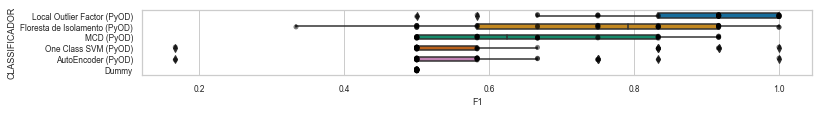

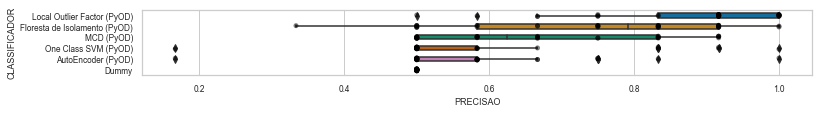

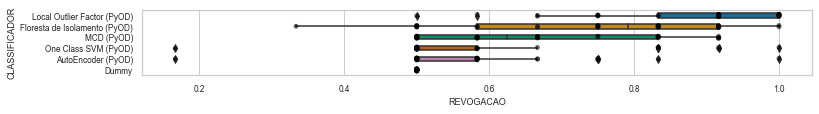

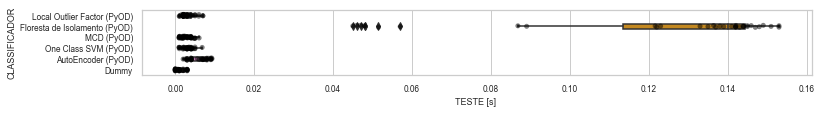

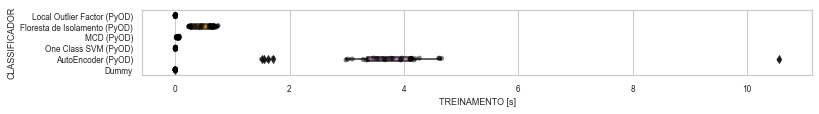

In [19]:
sns.set(font_scale=0.75, style="whitegrid")
for score in scores.columns.drop(['CLASSIFICADOR']):
    plt.figure(figsize=(12,1.2))
    bplot=sns.boxplot(y='CLASSIFICADOR', x=score, data=scores, width=0.4, 
                      palette='colorblind', order=list(mean_score_table.index));
    bplot=sns.stripplot(y='CLASSIFICADOR', x=score, data=scores, jitter=True, marker='o', 
                        alpha=0.5, color='black', order=list(mean_score_table.index))

## 4. Conclusão

Tendo em vista os resultados apresentados acima, podemos afirmar que o classificador "XXX" apresenta o melhor desempenho em termos de médias das métricas medida-F1, precisão e revogação, mas não em termos do desvio padrão dessas métricas nem dos tempos de treinamento e teste.

Após uma análise comparativa múltipla não paramétrica, verificamos que o classificador "XXX" produz um valor médio de medida-F1 estatisticamente diferente em comparação ao classificador Dummy.

In [20]:
# Calcular tempo total do notebook Jupyter
print(f'Tempo total de execução (hh:mm:ss.ms): {datetime.now() - start_time}')

Tempo total de execução (hh:mm:ss.ms): 0:03:51.174061
